### Часть 1: Используя средства Spark ML построить и протестировать модели осуществляющее классификацию и кластеризацию для датасета “Ирисы Фишера” 


In [125]:
import findspark

In [2]:
findspark.init('C:\\spark\\spark-3.3.1-bin-hadoop2\\')

In [3]:
import pyspark
pyspark.__version__

'3.3.1'

In [4]:
import sys
print(sys.version)

3.8.20 (default, Oct  3 2024, 15:19:54) [MSC v.1929 64 bit (AMD64)]


In [5]:
import os
# os.environ['JAVA_HOME'] = 'C:\\java\\jdk-11.0.2'
os.environ['JAVA_HOME'] = 'C:\\java\\jdk'
os.environ['PATH'] = os.environ['JAVA_HOME'] + '\\bin;' + os.environ['PATH']
os.environ['SPARK_HOME'] = 'C:\\spark\\spark-3.3.1-bin-hadoop2'
os.environ['HADOOP_HOME'] = 'C:\\hadoop'
os.environ['PATH'] = os.environ['SPARK_HOME'] + '\\bin;' + os.environ['PATH']
os.environ['PATH'] = os.environ['HADOOP_HOME'] + '\\bin;' + os.environ['PATH']

print(os.environ['JAVA_HOME'])
print(os.environ['SPARK_HOME'])
print(os.environ['HADOOP_HOME'])

C:\java\jdk
C:\spark\spark-3.3.1-bin-hadoop2
C:\hadoop


In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, LongType, FloatType, ArrayType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.sql.functions import udf
from pyspark.ml.linalg import DenseVector

- **Классификация**

In [7]:
# Создание Spark сессии
spark = SparkSession.builder \
                    .appName("IrisClassification") \
                    .getOrCreate()

In [7]:
from sklearn.datasets import load_iris
import numpy as np

In [9]:
iris = load_iris()

In [10]:
iris.data

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [11]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [12]:
# Сформируем датасет
iris = np.concatenate([iris.data, iris.target.reshape(-1, 1)], axis=1)

In [13]:
iris

array([[5.1, 3.5, 1.4, 0.2, 0. ],
       [4.9, 3. , 1.4, 0.2, 0. ],
       [4.7, 3.2, 1.3, 0.2, 0. ],
       [4.6, 3.1, 1.5, 0.2, 0. ],
       [5. , 3.6, 1.4, 0.2, 0. ],
       [5.4, 3.9, 1.7, 0.4, 0. ],
       [4.6, 3.4, 1.4, 0.3, 0. ],
       [5. , 3.4, 1.5, 0.2, 0. ],
       [4.4, 2.9, 1.4, 0.2, 0. ],
       [4.9, 3.1, 1.5, 0.1, 0. ],
       [5.4, 3.7, 1.5, 0.2, 0. ],
       [4.8, 3.4, 1.6, 0.2, 0. ],
       [4.8, 3. , 1.4, 0.1, 0. ],
       [4.3, 3. , 1.1, 0.1, 0. ],
       [5.8, 4. , 1.2, 0.2, 0. ],
       [5.7, 4.4, 1.5, 0.4, 0. ],
       [5.4, 3.9, 1.3, 0.4, 0. ],
       [5.1, 3.5, 1.4, 0.3, 0. ],
       [5.7, 3.8, 1.7, 0.3, 0. ],
       [5.1, 3.8, 1.5, 0.3, 0. ],
       [5.4, 3.4, 1.7, 0.2, 0. ],
       [5.1, 3.7, 1.5, 0.4, 0. ],
       [4.6, 3.6, 1. , 0.2, 0. ],
       [5.1, 3.3, 1.7, 0.5, 0. ],
       [4.8, 3.4, 1.9, 0.2, 0. ],
       [5. , 3. , 1.6, 0.2, 0. ],
       [5. , 3.4, 1.6, 0.4, 0. ],
       [5.2, 3.5, 1.5, 0.2, 0. ],
       [5.2, 3.4, 1.4, 0.2, 0. ],
       [4.7, 3

In [60]:
schema = StructType([
    StructField("sepal_length_cm", DoubleType(), True),
    StructField("sepal_width_cm", DoubleType(), True),
    StructField("petal_length_cm", DoubleType(), True),
    StructField("petal_width_cm", DoubleType(), True),
    StructField("target", DoubleType(), True)
])

In [15]:
iris = spark.createDataFrame(iris.tolist(), schema=schema)

In [16]:
iris.withColumn("target", iris["target"].cast(IntegerType()))

DataFrame[sepal_length_cm: double, sepal_width_cm: double, petal_length_cm: double, petal_width_cm: double, target: int]

In [17]:
vector_transformer = VectorAssembler(inputCols=["sepal_length_cm", "sepal_width_cm", "petal_length_cm", "petal_width_cm"],
                                     outputCol="features")
data = vector_transformer.transform(iris)

In [18]:
data.show(10, truncate=False)

+---------------+--------------+---------------+--------------+------+-----------------+
|sepal_length_cm|sepal_width_cm|petal_length_cm|petal_width_cm|target|features         |
+---------------+--------------+---------------+--------------+------+-----------------+
|5.1            |3.5           |1.4            |0.2           |0.0   |[5.1,3.5,1.4,0.2]|
|4.9            |3.0           |1.4            |0.2           |0.0   |[4.9,3.0,1.4,0.2]|
|4.7            |3.2           |1.3            |0.2           |0.0   |[4.7,3.2,1.3,0.2]|
|4.6            |3.1           |1.5            |0.2           |0.0   |[4.6,3.1,1.5,0.2]|
|5.0            |3.6           |1.4            |0.2           |0.0   |[5.0,3.6,1.4,0.2]|
|5.4            |3.9           |1.7            |0.4           |0.0   |[5.4,3.9,1.7,0.4]|
|4.6            |3.4           |1.4            |0.3           |0.0   |[4.6,3.4,1.4,0.3]|
|5.0            |3.4           |1.5            |0.2           |0.0   |[5.0,3.4,1.5,0.2]|
|4.4            |2.9 

In [19]:
data = data.sample(withReplacement=False, fraction=1.0, seed=42)
data_train, data_test = data.randomSplit([0.8, 0.2], seed=42)

In [20]:
print(f'Количество строк в трейне: {data_train.count()} \n'
      f'Количество строк в тесте: {data_test.count()}')

Количество строк в трейне: 124 
Количество строк в тесте: 26


In [21]:
rf_model = RandomForestClassifier(labelCol="target", featuresCol="features", numTrees=5)
rf_model = rf_model.fit(data_train)
rf_pred = rf_model.transform(data_test)

In [22]:
logreg_model = LogisticRegression(labelCol="target", featuresCol="features")
logreg_model = logreg_model.fit(data_train)
logreg_pred = logreg_model.transform(data_test)

In [23]:
nb_model = NaiveBayes(labelCol="target", featuresCol="features")
nb_model = nb_model.fit(data_train)
nb_pred = nb_model.transform(data_test)

In [24]:
models_preds = [
    ("Random Forest", rf_pred),
    ("Logistic Regression", logreg_pred),
    ("Naive Bayes", nb_pred)
]

In [25]:
eval = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction")
for model, pred in models_preds:
    accuracy = eval.setMetricName("accuracy").evaluate(pred)
    precision = eval.setMetricName("weightedPrecision").evaluate(pred)
    recall = eval.setMetricName("weightedRecall").evaluate(pred)
    f1 = eval.setMetricName("f1").evaluate(pred)
    print(f"{model} classifier metrics:")
    print(f"  Accuracy: {accuracy}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1-score: {f1}\n")

Random Forest classifier metrics:
  Accuracy: 0.8846153846153846
  Precision: 0.9230769230769231
  Recall: 0.8846153846153846
  F1-score: 0.885972850678733

Logistic Regression classifier metrics:
  Accuracy: 0.8461538461538461
  Precision: 0.9076923076923078
  Recall: 0.8461538461538463
  F1-score: 0.846153846153846

Naive Bayes classifier metrics:
  Accuracy: 0.7307692307692307
  Precision: 0.8757396449704142
  Recall: 0.7307692307692308
  F1-score: 0.7078791653690439



- **Кластеризация**

In [7]:
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [29]:
kmeans = KMeans(featuresCol="features", k=3, seed=42)
kmeans_model = kmeans.fit(data_train)
kmeans_pred = kmeans_model.transform(data_test)

In [30]:
gmm = GaussianMixture(featuresCol="features", k=3, seed=42)
gmm_model = gmm.fit(data_train)
gmm_pred = gmm_model.transform(data_test)

In [33]:
models_preds_clust = [
    ("K-Means", kmeans_pred ),
    ("Gaussian Mixture", gmm_pred)
]

In [36]:
eval = ClusteringEvaluator(featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
for model, pred in models_preds_clust:
    sil = eval.evaluate(pred)
    print(f"{model} classifier metrics:")
    print(f"  Silhouette score: {sil}")

K-Means classifier metrics:
  Silhouette score: 0.7712335636714577
Gaussian Mixture classifier metrics:
  Silhouette score: 0.6796203648229899


In [40]:
spark.stop()

### Часть 2: Используя средства Spark ML для всех 5 датасетов надо провести 3 эксперимента с построением моделей на датасета, которые позволят что-то сказать о данных, зависимотях между ними атрибутами, обозначить какие кластеры есть в датасетах и тп


### **1) 2024 Youtube Channels (1 Million)**

In [39]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

api.dataset_download_files('asaniczka/2024-youtube-channels-1-million', path='./', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/asaniczka/2024-youtube-channels-1-million


In [2]:
# Создание Spark сессии
spark = SparkSession.builder \
                    .appName("YouTubeDataset") \
                    .getOrCreate()

In [3]:
you_tube_path = "youtube_channels_1M_clean.csv"

In [4]:
data = spark.read.csv(you_tube_path, sep=',', quote='"', header=True, inferSchema=True)

In [5]:
data.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+---------+-------------------------+---------------------------+------------------------+---------------+
|          channel_id|        channel_link|        channel_name|    subscriber_count|         banner_link|         description|            keywords|              avatar|             country|         total_views|total_videos|join_date|mean_views_last_30_videos|median_views_last_30_videos|std_views_last_30_videos|videos_per_week|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+---------+-------------------------+---------------------------+------------------------+---------------+
|UCUMHFa34

In [6]:
num_rows = data.count()
num_columns = len(data.columns)
print(f"Количество строк: {num_rows}")
print(f"Количество колонок: {num_columns}")

Количество строк: 3498276
Количество колонок: 16


In [7]:
data.printSchema()

root
 |-- channel_id: string (nullable = true)
 |-- channel_link: string (nullable = true)
 |-- channel_name: string (nullable = true)
 |-- subscriber_count: string (nullable = true)
 |-- banner_link: string (nullable = true)
 |-- description: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- avatar: string (nullable = true)
 |-- country: string (nullable = true)
 |-- total_views: string (nullable = true)
 |-- total_videos: string (nullable = true)
 |-- join_date: string (nullable = true)
 |-- mean_views_last_30_videos: string (nullable = true)
 |-- median_views_last_30_videos: string (nullable = true)
 |-- std_views_last_30_videos: string (nullable = true)
 |-- videos_per_week: string (nullable = true)



> Сначала определимся, что будем делать с датасетом.
> Попробуем предсказывать количество подписчиков по некоторым параметрам.
> Выберем следующие колонки:
> - subscriber_count - наш таргет
> - total_views
> - total_videos
> - median_views_last_30_videos
> - std_views_last_30_videos
> - videos_per_week
> - join_date

In [8]:
# Оставим только перечисленные колонки
columns_to_keep = ['subscriber_count',
                   'total_views',
                   'total_videos',
                   'mean_views_last_30_videos',
                   'std_views_last_30_videos',
                   'videos_per_week',
                   'join_date']

In [9]:
data_cleaned = data.select(columns_to_keep).dropna()

##### Ниже видно, что нужно будет поработать над датой

In [10]:
data_cleaned.select('join_date').show(20)

+--------------------+
|           join_date|
+--------------------+
|         Indian Food|
|   singersongwriters|
|          2023-12-21|
|          2017-09-11|
|          2014-10-11|
|          2022-07-31|
|          investment|
|              preppy|
|          2021-10-31|
|          2011-05-10|
|               stats|
|          2017-06-06|
| my little pony f...|
|          2017-08-03|
|          2022-03-01|
|          2020-03-03|
|          2022-10-15|
|          2024-02-29|
|          2013-07-02|
|          2011-02-28|
+--------------------+
only showing top 20 rows



In [11]:
from pyspark.sql.types import DoubleType, DateType
from pyspark.sql.functions import col, to_date, datediff, round, expr, lit, min, count, when

In [12]:
data_cleaned = data_cleaned.withColumn('join_date', to_date(col('join_date'), 'yyyy-MM-dd'))
data_cleaned = data_cleaned.filter(col('join_date').isNotNull())

In [13]:
data_cleaned = data_cleaned.withColumn('days_since_2005_02_14', datediff(col('join_date'), lit('2005-02-14')))
data_cleaned = data_cleaned.drop('join_date')

In [14]:
columns_res = [
    'subscriber_count',
    'total_views',
    'total_videos',
    'mean_views_last_30_videos',
    'std_views_last_30_videos',
    'videos_per_week',
    'days_since_2005_02_14'
]
columns_fit = [
    'total_views',
    'total_videos',
    'mean_views_last_30_videos',
    'std_views_last_30_videos',
    'videos_per_week',
    'days_since_2005_02_14'
]
columns_target = ['subscriber_count']

In [15]:
for colmn in columns_res:
    data_cleaned  = data_cleaned .withColumn(colmn, round(data_cleaned [colmn].cast(IntegerType()), 3))
data_cleaned = data_cleaned.dropna()

In [16]:
data_cleaned.show()

+----------------+-----------+------------+-------------------------+------------------------+---------------+---------------------+
|subscriber_count|total_views|total_videos|mean_views_last_30_videos|std_views_last_30_videos|videos_per_week|days_since_2005_02_14|
+----------------+-----------+------------+-------------------------+------------------------+---------------+---------------------+
|            1160|     288328|         476|                       85|                      72|              1|                 6884|
|            5670|     737050|         460|                      980|                     158|              2|                 4592|
|            1640|      45488|           6|                     7583|                    5640|              0|                 3526|
|            2340|    1835178|          22|                    91697|                  344370|              0|                 6376|
|          230000|   48244849|          83|                   282393|

In [17]:
data_cleaned.printSchema()

root
 |-- subscriber_count: integer (nullable = true)
 |-- total_views: integer (nullable = true)
 |-- total_videos: integer (nullable = true)
 |-- mean_views_last_30_videos: integer (nullable = true)
 |-- std_views_last_30_videos: integer (nullable = true)
 |-- videos_per_week: integer (nullable = true)
 |-- days_since_2005_02_14: integer (nullable = true)



In [18]:
num_rows = data_cleaned.count()
num_columns = len(data_cleaned .columns)
print(f"Количество строк: {num_rows}")
print(f"Количество колонок: {num_columns}")

Количество строк: 550741
Количество колонок: 7


In [19]:
data_train, data_test = data_cleaned.randomSplit([0.95, 0.05], seed=42)

In [20]:
num_rows_train = data_train.count()
num_rows_test = data_test.count()
print(f"Количество строк в TRAIN: {num_rows_train}")
print(f"Количество строк в TEST: {num_rows_test}")

Количество строк в TRAIN: 523049
Количество строк в TEST: 27692


Возьмем данные с 0.5 по 99.5 процентиля

In [21]:
percentiles = {}
for colmn in columns_res:
    percentiles[colmn] = data_train.approxQuantile(colmn, [0.005, 0.995], relativeError=0.0)

In [22]:
conditions = (col(columns_res[0]) >= percentiles[columns_res[0]][0]) & \
             (col(columns_res[0]) <= percentiles[columns_res[0]][1])
for colmn in columns_res[1:]:
    conditions = conditions & (col(colmn) >= percentiles[colmn][0]) & (col(colmn) <= percentiles[colmn][1])

In [23]:
data_train_filtered = data_train.filter(conditions)
data_test_filtered = data_test.filter(conditions)

In [26]:
num_rows_train = data_train_filtered.count()
num_rows_test = data_test_filtered.count()
print(f"Количество строк в TRAIN после обрезки: {num_rows_train}")
print(f"Количество строк в TEST после обрезки: {num_rows_test}")

Количество строк в TRAIN после обрезки: 506003
Количество строк в TEST после обрезки: 26803


In [27]:
data_train_filtered.describe().show()

+-------+------------------+--------------------+-----------------+-------------------------+------------------------+------------------+---------------------+
|summary|  subscriber_count|         total_views|     total_videos|mean_views_last_30_videos|std_views_last_30_videos|   videos_per_week|days_since_2005_02_14|
+-------+------------------+--------------------+-----------------+-------------------------+------------------------+------------------+---------------------+
|  count|            506003|              506003|           506003|                   506003|                  506003|            506003|               506003|
|   mean| 8683.919010361598|  2265143.3450750294|198.5147084108197|        7838.068167580034|      13991.817341003907|0.3000100789916265|     4001.35406114193|
| stddev|51470.873882863256|1.4052083762082757E7|471.9755352938862|       41977.395645790006|       77175.06302394446|1.1142112783296614|   1714.9934864685226|
|    min|                 0|            

In [28]:
# Посмотрим на корреляции
from pyspark.ml.stat import Correlation

In [29]:
vector_transformer = VectorAssembler(inputCols=columns_res, outputCol='features')
data_vector_train = vector_transformer.transform(data_train_filtered).select('features')

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
correlation_matrix = Correlation.corr(data_vector_train, 'features').head()[0]
corr_matrix_np = correlation_matrix.toArray()

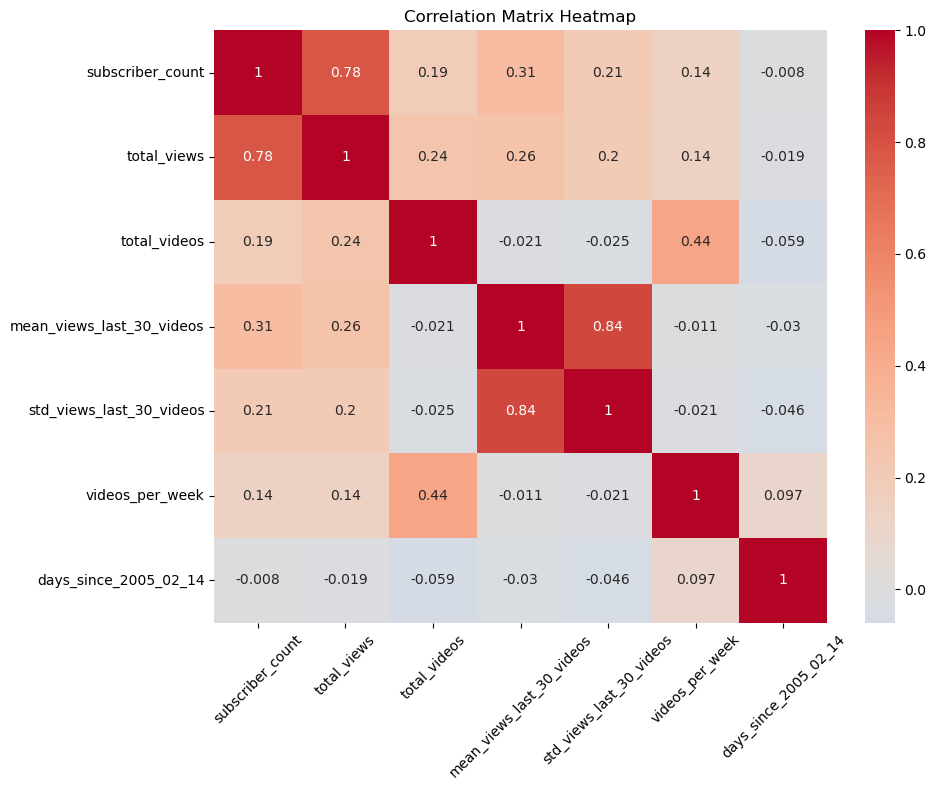

In [32]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_np,
            annot=True,
            xticklabels=columns_res,
            yticklabels=columns_res,
            cmap='coolwarm',
            center=0
           )
plt.title("Correlation Matrix Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [33]:
from pyspark.ml.feature import StandardScaler

In [34]:
vector_transformer = VectorAssembler(inputCols=columns_fit, outputCol='features')
data_vector_train = vector_transformer.transform(data_train_filtered)
data_vector_test = vector_transformer.transform(data_test_filtered)

In [35]:
data_vector_train.show()

+----------------+-----------+------------+-------------------------+------------------------+---------------+---------------------+--------------------+
|subscriber_count|total_views|total_videos|mean_views_last_30_videos|std_views_last_30_videos|videos_per_week|days_since_2005_02_14|            features|
+----------------+-----------+------------+-------------------------+------------------------+---------------+---------------------+--------------------+
|               0|          9|           1|                        9|                       0|              0|                 4647|[9.0,1.0,9.0,0.0,...|
|               0|          9|           1|                        9|                       0|              0|                 5072|[9.0,1.0,9.0,0.0,...|
|               0|          9|           1|                        9|                       0|              0|                 5734|[9.0,1.0,9.0,0.0,...|
|               0|          9|           1|                        9|       

In [36]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(data_vector_train)
data_scaled_train = scaler_model.transform(data_vector_train)
data_scaled_test = scaler_model.transform(data_vector_test)

In [37]:
data_scaled_train.show(truncate=False)

+----------------+-----------+------------+-------------------------+------------------------+---------------+---------------------+------------------------------+------------------------------------------------------------------------------------------------------------------------------+
|subscriber_count|total_views|total_videos|mean_views_last_30_videos|std_views_last_30_videos|videos_per_week|days_since_2005_02_14|features                      |scaled_features                                                                                                               |
+----------------+-----------+------------+-------------------------+------------------------+---------------+---------------------+------------------------------+------------------------------------------------------------------------------------------------------------------------------+
|0               |9          |1           |9                        |0                       |0              |4647             

In [11]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor

In [200]:
linreg = LinearRegression(featuresCol="scaled_features", labelCol="subscriber_count")
linreg_model = linreg.fit(data_scaled_train)
linreg_pred = linreg_model.transform(data_scaled_test)

In [219]:
eval = RegressionEvaluator(labelCol="subscriber_count", predictionCol="prediction")
rmse = eval.setMetricName("rmse").evaluate(linreg_pred)
mae = eval.setMetricName("mae").evaluate(linreg_pred)
r2 = eval.setMetricName("r2").evaluate(linreg_pred)
mse = eval.setMetricName("mse").evaluate(linreg_pred)
print(f"Linear Regressiom regression metrics on test:")
print(f"  RMSE: {rmse}")
print(f"  MAE: {mae}")
print(f"  R2: {r2}")
print(f"  MSE: {mse}\n")

Linear Regressiom regression metrics on test:
  RMSE: 44448.948090074686
  MAE: 10849.128632356766
  R2: 0.5104289469271908
  MSE: 1975708986.314154



In [224]:
rfreg = RandomForestRegressor(featuresCol="scaled_features", labelCol="subscriber_count", numTrees=10)
rfreg_model = rfreg.fit(data_scaled_train)
rfreg_pred = rfreg_model.transform(data_scaled_test)

In [225]:
eval = RegressionEvaluator(labelCol="subscriber_count", predictionCol="prediction")
rmse = eval.setMetricName("rmse").evaluate(rfreg_pred)
mae = eval.setMetricName("mae").evaluate(rfreg_pred)
r2 = eval.setMetricName("r2").evaluate(rfreg_pred)
mse = eval.setMetricName("mse").evaluate(rfreg_pred)
print(f"Random Forest Regressor regression metrics on test:")
print(f"  RMSE: {rmse}")
print(f"  MAE: {mae}")
print(f"  R2: {r2}")
print(f"  MSE: {mse}\n")

Random Forest Regressor regression metrics on test:
  RMSE: 43836.90123464967
  MAE: 8688.695390843941
  R2: 0.5238185753934913
  MSE: 1921673909.8564298



In [11]:
from pyspark.ml.feature import PCA

In [242]:
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca")
pca_model = pca.fit(data_scaled_train)
pca_res_test = pca_model.transform(data_scaled_test)
pca_res_train = pca_model.transform(data_scaled_train)

In [13]:
from pyspark.ml.functions import vector_to_array

In [244]:
pca_res_train = pca_res_train.withColumn("pca_array", vector_to_array("pca"))
pca_res_test = pca_res_test.withColumn("pca_array", vector_to_array("pca"))

pca_res_train = pca_res_train.withColumn("PC1", col("pca_array")[0]).withColumn("PC2", col("pca_array")[1])
pca_res_test = pca_res_test.withColumn("PC1", col("pca_array")[0]).withColumn("PC2", col("pca_array")[1])

In [245]:
train_numpy = np.array(pca_res_train.select("PC1", "PC2").collect())
test_numpy = np.array(pca_res_test.select("PC1", "PC2").collect())

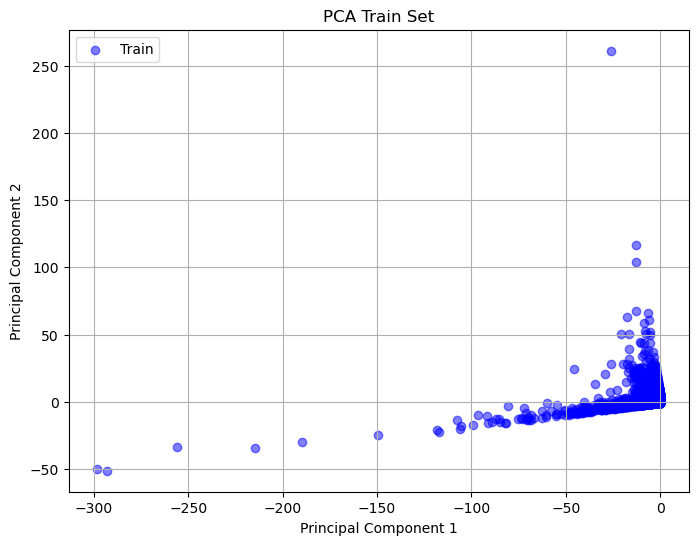

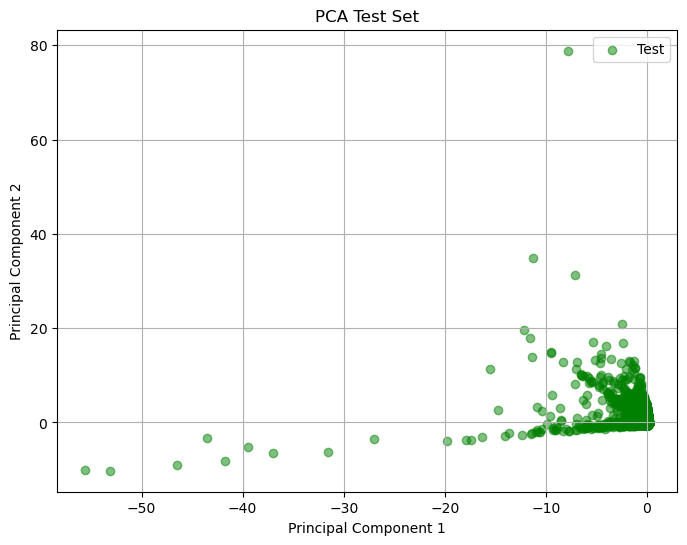

In [246]:
plt.figure(figsize=(8, 6))
plt.scatter(train_numpy[:, 0], train_numpy[:, 1], alpha=0.5, label='Train', color='blue')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Train Set')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(test_numpy[:, 0], test_numpy[:, 1], alpha=0.5, label='Test', color='green')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Test Set')
plt.grid(True)
plt.legend()
plt.show()

In [248]:
spark.stop()

### **2) Credit Card Fraud Detection**

In [247]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

api.dataset_download_files('mlg-ulb/creditcardfraud', path='./', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud


In [12]:
# Создание Spark сессии
spark = SparkSession.builder \
                    .appName("CreditDataset") \
                    .getOrCreate()

In [13]:
credit_path = "creditcard.csv"

In [14]:
data = spark.read.csv(credit_path, header=True)

In [15]:
data.show(5)

+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                 V21|                V22|     

In [16]:
num_rows = data.count()
num_columns = len(data.columns)
print(f"Количество строк: {num_rows}")
print(f"Количество колонок: {num_columns}")

Количество строк: 284807
Количество колонок: 31


In [17]:
data.printSchema()

root
 |-- Time: string (nullable = true)
 |-- V1: string (nullable = true)
 |-- V2: string (nullable = true)
 |-- V3: string (nullable = true)
 |-- V4: string (nullable = true)
 |-- V5: string (nullable = true)
 |-- V6: string (nullable = true)
 |-- V7: string (nullable = true)
 |-- V8: string (nullable = true)
 |-- V9: string (nullable = true)
 |-- V10: string (nullable = true)
 |-- V11: string (nullable = true)
 |-- V12: string (nullable = true)
 |-- V13: string (nullable = true)
 |-- V14: string (nullable = true)
 |-- V15: string (nullable = true)
 |-- V16: string (nullable = true)
 |-- V17: string (nullable = true)
 |-- V18: string (nullable = true)
 |-- V19: string (nullable = true)
 |-- V20: string (nullable = true)
 |-- V21: string (nullable = true)
 |-- V22: string (nullable = true)
 |-- V23: string (nullable = true)
 |-- V24: string (nullable = true)
 |-- V25: string (nullable = true)
 |-- V26: string (nullable = true)
 |-- V27: string (nullable = true)
 |-- V28: string (nulla

In [21]:
for colmn in data.columns:
    data  = data.withColumn(colmn, round(data[colmn].cast(FloatType()), 3))
data = data.dropna()

In [22]:
num_rows = data.count()
num_columns = len(data.columns)
print(f"Количество строк: {num_rows}")
print(f"Количество колонок: {num_columns}")

Количество строк: 284807
Количество колонок: 31


In [23]:
unique_classes = data.select('Class').distinct().show()

+-----+
|Class|
+-----+
|  1.0|
|  0.0|
+-----+



In [24]:
class_counts = data.groupBy('Class').count()
class_counts.show()

+-----+------+
|Class| count|
+-----+------+
|  1.0|   492|
|  0.0|284315|
+-----+------+



- Посмотрим на корреляцию

In [26]:
vector_transformer = VectorAssembler(inputCols=data.columns, outputCol='features')
data = vector_transformer.transform(data)

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
correlation_matrix = Correlation.corr(data, 'features').head()[0]
corr_matrix_np = correlation_matrix.toArray()

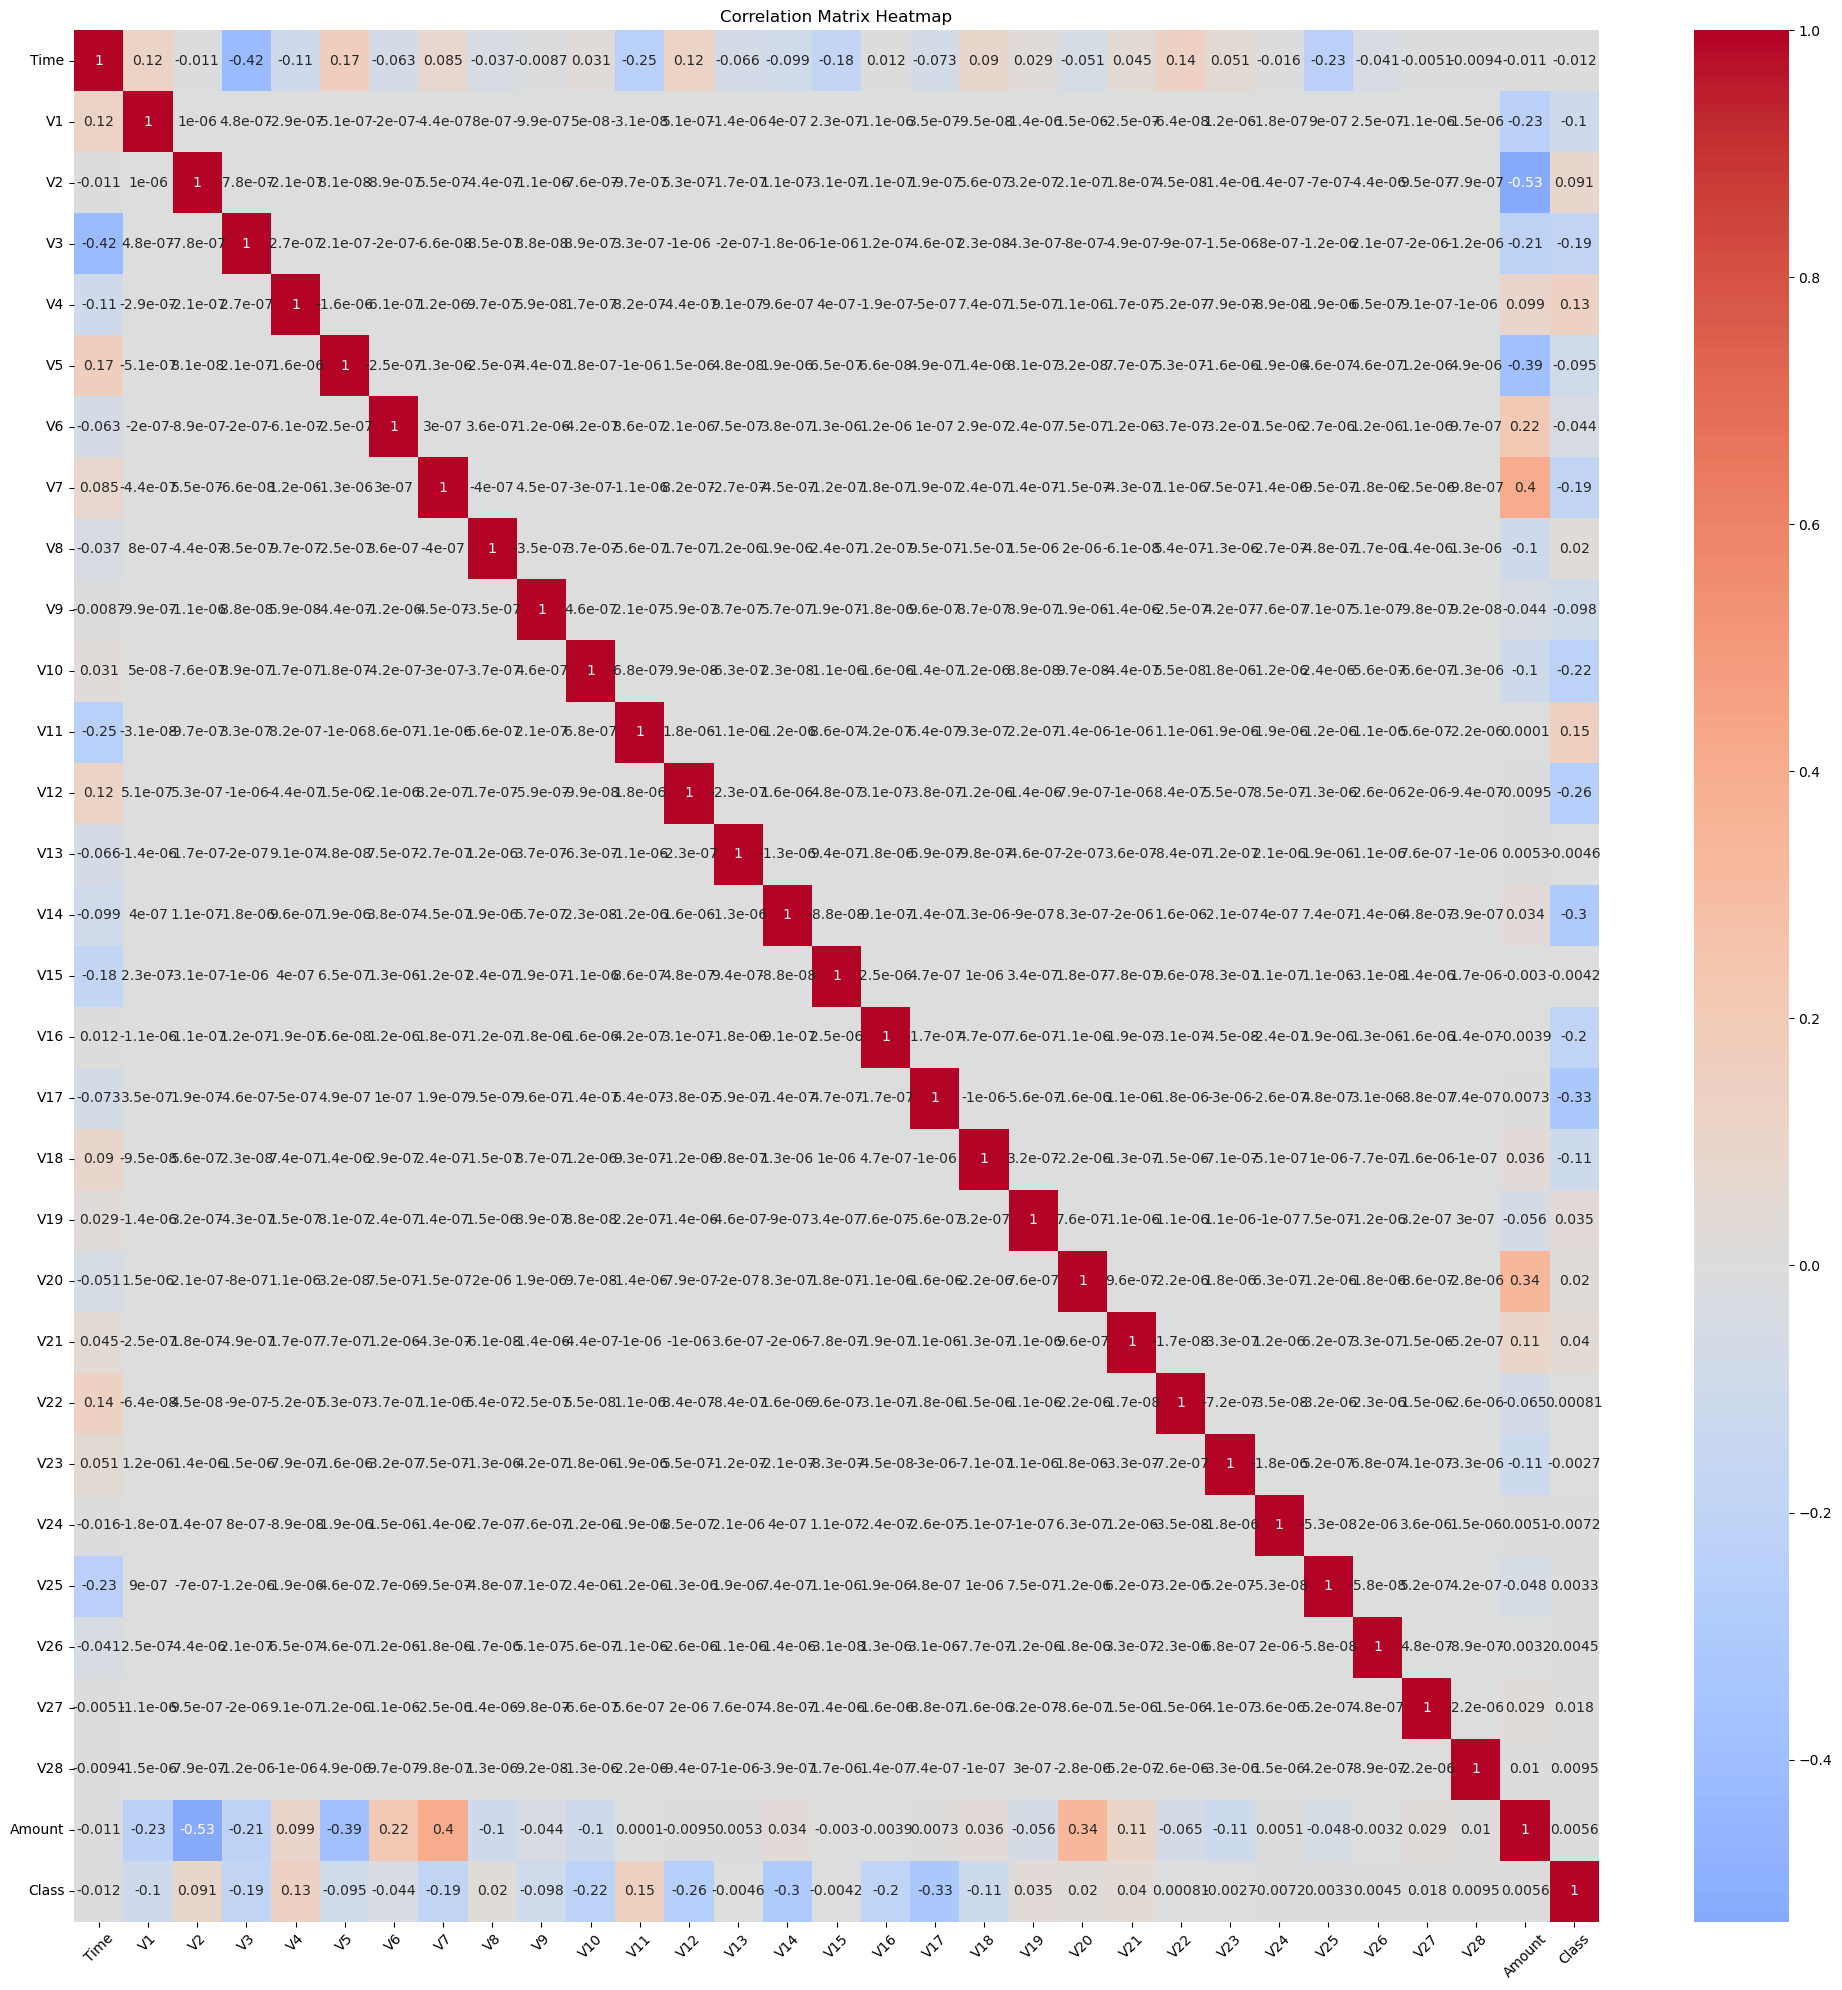

In [29]:
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix_np,
            annot=True,
            xticklabels=data.columns[:-1],
            yticklabels=data.columns[:-1],
            cmap='coolwarm',
            center=0
           )
plt.title("Correlation Matrix Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

- Попробуем спрогнозировать мошенническую транзакцию

In [30]:
columns_fit = data.columns[:-2]
columns_target = ['Class']

In [31]:
data_train, data_test = data.randomSplit([0.9, 0.1], seed=42)

In [32]:
num_rows_train = data_train.count()
num_rows_test = data_test.count()
print(f"Количество строк в TRAIN: {num_rows_train}")
print(f"Количество строк в TEST: {num_rows_test}")

Количество строк в TRAIN: 256463
Количество строк в TEST: 28344


In [12]:
from pyspark.ml.feature import StandardScaler

In [34]:
vector_transformer_fit = VectorAssembler(inputCols=columns_fit, outputCol='features')
data_vector_train = vector_transformer_fit.transform(data_train.select(data_train.columns[:-1]))
data_vector_test = vector_transformer_fit.transform(data_test.select(data_test.columns[:-1]))

In [35]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(data_vector_train)
data_scaled_train = scaler_model.transform(data_vector_train)
data_scaled_test = scaler_model.transform(data_vector_test)

In [36]:
rf_model = RandomForestClassifier(labelCol="Class", featuresCol="scaled_features", numTrees=5)
rf_model = rf_model.fit(data_scaled_train)
rf_pred = rf_model.transform(data_scaled_test)

In [37]:
logreg_model = LogisticRegression(labelCol="Class", featuresCol="scaled_features")
logreg_model = logreg_model.fit(data_scaled_train)
logreg_pred = logreg_model.transform(data_scaled_test)

In [38]:
models_preds = [
    ("Random Forest", rf_pred),
    ("Logistic Regression", logreg_pred)
]

In [39]:
eval = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction")
for model, pred in models_preds:
    accuracy = eval.setMetricName("accuracy").evaluate(pred)
    precision = eval.setMetricName("weightedPrecision").evaluate(pred)
    recall = eval.setMetricName("weightedRecall").evaluate(pred)
    f1 = eval.setMetricName("f1").evaluate(pred)
    print(f"{model} classifier metrics:")
    print(f"  Accuracy: {accuracy}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1-score: {f1}\n")

Random Forest classifier metrics:
  Accuracy: 0.9990826982782952
  Precision: 0.9990225011376829
  Recall: 0.9990826982782952
  F1-score: 0.9990327609172059

Logistic Regression classifier metrics:
  Accuracy: 0.9988710132655941
  Precision: 0.9987711376284093
  Recall: 0.9988710132655941
  F1-score: 0.9987859663444622



- Попробуем кластеризовать

In [52]:
vector_transformer_fit = VectorAssembler(inputCols=columns_fit[1:], outputCol='features1')
data_vector_train = vector_transformer_fit.transform(data_train.select(data_train.columns[1:-1]))
data_vector_test = vector_transformer_fit.transform(data_test.select(data_test.columns[1:-1]))

In [12]:
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [54]:
kmeans = KMeans(featuresCol='features1', k=2, seed=42)
kmeans_model = kmeans.fit(data_vector_train)
kmeans_pred = kmeans_model.transform(data_vector_test)

In [55]:
gmm = GaussianMixture(featuresCol='features1', k=2, seed=42)
gmm_model = gmm.fit(data_vector_train)
gmm_pred = gmm_model.transform(data_vector_test)

In [56]:
models_preds_clust = [
    ("K-Means", kmeans_pred ),
    ("Gaussian Mixture", gmm_pred)
]

In [57]:
eval = ClusteringEvaluator(featuresCol="features1", metricName='silhouette', distanceMeasure='squaredEuclidean')
for model, pred in models_preds_clust:
    sil = eval.evaluate(pred)
    print(f"{model} classifier metrics:")
    print(f"  Silhouette score: {sil}")

K-Means classifier metrics:
  Silhouette score: 0.9705797783234165
Gaussian Mixture classifier metrics:
  Silhouette score: 0.722450401195119


In [38]:
spark.stop()

### **3) Public bike use data 2014-2024**

In [27]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

api.dataset_download_files('sebastianquirarte/over-9-years-of-real-public-bike-use-data-mibici', path='./', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/sebastianquirarte/over-9-years-of-real-public-bike-use-data-mibici


In [39]:
# Создание Spark сессии
spark = SparkSession.builder \
                    .appName("PublicBikeDataset") \
                    .getOrCreate()

In [40]:
bike_path = r"mibici_2014-2024\mibici_2014-2024.csv"

In [41]:
data = spark.read.csv(bike_path, header=True)

In [42]:
data.show(5, truncate=False)

+---+--------+-------+---+----------+-------------------+-------------------+---------+--------------+---+---------------+
|_c0|Trip_Id |User_Id|Sex|Birth_year|Trip_start         |Trip_end           |Origin_Id|Destination_Id|Age|Duration       |
+---+--------+-------+---+----------+-------------------+-------------------+---------+--------------+---+---------------+
|0  |32244893|1470734|M  |1981      |2024-01-31 23:59:33|2024-02-01 00:11:15|24       |86            |43 |0 days 00:11:42|
|1  |32244892|2731702|M  |1994      |2024-01-31 23:59:06|2024-02-01 00:10:49|48       |279           |30 |0 days 00:11:43|
|2  |32244891|1431452|M  |2001      |2024-01-31 23:58:48|2024-02-01 00:01:42|273      |383           |23 |0 days 00:02:54|
|3  |32244890|2312602|F  |2003      |2024-01-31 23:58:44|2024-02-01 00:01:58|273      |383           |21 |0 days 00:03:14|
|4  |32244889|2266427|M  |1999      |2024-01-31 23:58:44|2024-02-01 00:01:39|273      |383           |25 |0 days 00:02:55|
+---+--------+--

In [43]:
data = data.dropna()

In [44]:
num_rows = data.count()
num_columns = len(data.columns)
print(f"Количество строк: {num_rows}")
print(f"Количество колонок: {num_columns}")

Количество строк: 25863690
Количество колонок: 11


- Вытащим из датафрейма инфформацию.
- Закодируем пол, оставим возраст, вычислим время поездок в секундах

In [45]:
data = data.withColumn("Sex_binary", when(col("Sex") == "M", 1).otherwise(0)).dropna()

In [46]:
from pyspark.sql.functions import to_timestamp, from_unixtime, unix_timestamp

In [47]:
data = data.withColumn("Trip_start", to_timestamp(col("Trip_start"), "yyyy-MM-dd HH:mm:ss"))
data = data.withColumn("Trip_end", to_timestamp(col("Trip_end"), "yyyy-MM-dd HH:mm:ss"))

In [48]:
data = data.withColumn("duration_sec", unix_timestamp("Trip_end") - unix_timestamp("Trip_start"))

In [49]:
data_to_analyse = data.select(['duration_sec', 'Sex_binary', 'Age'])

In [50]:
data_to_analyse = data_to_analyse.withColumn('Age', data_to_analyse['Age'].cast(IntegerType()))

In [51]:
data_to_analyse.show(5, truncate=False)

+------------+----------+---+
|duration_sec|Sex_binary|Age|
+------------+----------+---+
|702         |1         |43 |
|703         |1         |30 |
|174         |1         |23 |
|194         |0         |21 |
|175         |1         |25 |
+------------+----------+---+
only showing top 5 rows



In [52]:
data_to_analyse.printSchema()

root
 |-- duration_sec: long (nullable = true)
 |-- Sex_binary: integer (nullable = false)
 |-- Age: integer (nullable = true)



- Посмотрим на корреляцию

In [53]:
vector_transformer = VectorAssembler(inputCols=data_to_analyse.columns, outputCol='features')
data_vector = vector_transformer.transform(data_to_analyse)

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.stat import Correlation

In [55]:
correlation_matrix = Correlation.corr(data_vector, 'features').head()[0]
corr_matrix_np = correlation_matrix.toArray()

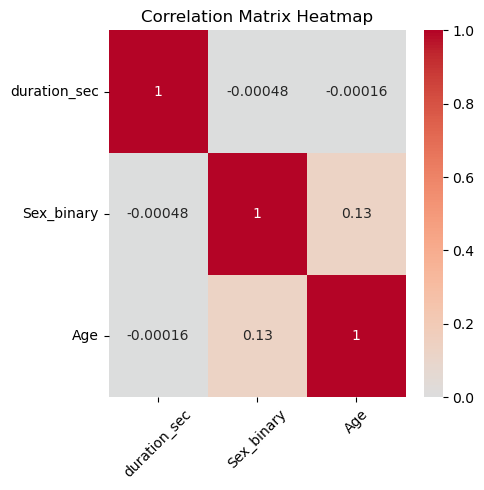

In [56]:
plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix_np,
            annot=True,
            xticklabels=data_to_analyse.columns,
            yticklabels=data_to_analyse.columns,
            cmap='coolwarm',
            center=0
           )
plt.title("Correlation Matrix Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [57]:
columns_fit = ['Sex_binary', 'Age']

In [58]:
data_to_analyse = data_to_analyse.sample(withReplacement=False, fraction=0.1, seed=42)
data_train, data_test = data_to_analyse.randomSplit([0.9, 0.1], seed=42)

In [59]:
data_to_analyse.describe().show()

+-------+------------------+-------------------+-----------------+
|summary|      duration_sec|         Sex_binary|              Age|
+-------+------------------+-------------------+-----------------+
|  count|           2589130|            2589130|          2589130|
|   mean|1034.8663021941734| 0.7409921479415865|32.78372349012989|
| stddev| 62296.30584339002|0.43809001216289895|10.34869492161916|
|    min|                60|                  0|               16|
|    max|          26087490|                  1|              104|
+-------+------------------+-------------------+-----------------+



In [60]:
columns_res = ['duration_sec', 'Age']

In [61]:
percentiles = {}
for colmn in data_train.columns:
    percentiles[colmn] = data_train.approxQuantile(colmn, [0.1, 0.9], relativeError=0.0)

In [62]:
conditions = (col(columns_res[0]) >= percentiles[columns_res[0]][0]) & \
             (col(columns_res[0]) <= percentiles[columns_res[0]][1])
for colmn in columns_res:
    conditions = conditions & (col(colmn) >= percentiles[colmn][0]) & (col(colmn) <= percentiles[colmn][1])

In [63]:
data_train_filtered = data_train.filter(conditions)
data_test_filtered = data_test.filter(conditions)

In [64]:
data_train_filtered .describe().show()

+-------+------------------+------------------+------------------+
|summary|      duration_sec|        Sex_binary|               Age|
+-------+------------------+------------------+------------------+
|  count|           1551044|           1551044|           1551044|
|   mean| 622.3331066043258|0.7274048963149982|31.122478150200767|
| stddev|260.47752311905714|0.4452944430071472|6.6433409884503405|
|    min|               237|                 0|                22|
|    max|              1227|                 1|                48|
+-------+------------------+------------------+------------------+



In [65]:
vector_transformer = VectorAssembler(inputCols=columns_fit, outputCol='features')
data_vector_train = vector_transformer.transform(data_train_filtered)
data_vector_test = vector_transformer.transform(data_test_filtered)

In [66]:
data_vector_train.show(5, truncate=False)

+------------+----------+---+----------+
|duration_sec|Sex_binary|Age|features  |
+------------+----------+---+----------+
|237         |0         |23 |[0.0,23.0]|
|237         |0         |24 |[0.0,24.0]|
|237         |0         |25 |[0.0,25.0]|
|237         |0         |25 |[0.0,25.0]|
|237         |0         |25 |[0.0,25.0]|
+------------+----------+---+----------+
only showing top 5 rows



In [45]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor

In [46]:
linreg = LinearRegression(featuresCol="features", labelCol="duration_sec")
linreg_model = linreg.fit(data_vector_train)
linreg_pred = linreg_model.transform(data_vector_test)

In [47]:
eval = RegressionEvaluator(labelCol="duration_sec", predictionCol="prediction")
rmse = eval.setMetricName("rmse").evaluate(linreg_pred)
mae = eval.setMetricName("mae").evaluate(linreg_pred)
r2 = eval.setMetricName("r2").evaluate(linreg_pred)
mse = eval.setMetricName("mse").evaluate(linreg_pred)
print(f"Linear Regressiom regression metrics on test:")
print(f"  RMSE: {rmse}")
print(f"  MAE: {mae}")
print(f"  R2: {r2}")
print(f"  MSE: {mse}\n")

Linear Regressiom regression metrics on test:
  RMSE: 260.52210818092504
  MAE: 219.61693189042498
  R2: 0.0005725501460899229
  MSE: 67871.76885103362



In [48]:
from pyspark.ml.feature import PCA
import numpy as np

In [49]:
vector_transformer = VectorAssembler(inputCols=data_train_filtered.columns, outputCol='features')
data_vector = vector_transformer.transform(data_train_filtered)

In [50]:
pca = PCA(k=2, inputCol="features", outputCol="pca")
pca_model = pca.fit(data_vector)
pca_res_test = pca_model.transform(data_vector)

In [51]:
from pyspark.ml.functions import vector_to_array

In [52]:
pca_res_test = pca_res_test.withColumn("pca_array", vector_to_array("pca"))
pca_res_test = pca_res_test.withColumn("PC1", col("pca_array")[0]).withColumn("PC2", col("pca_array")[1])

In [53]:
test_numpy = np.array(pca_res_test.select("PC1", "PC2").collect())

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Programms\MiniConda\envs\pppppyspark\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


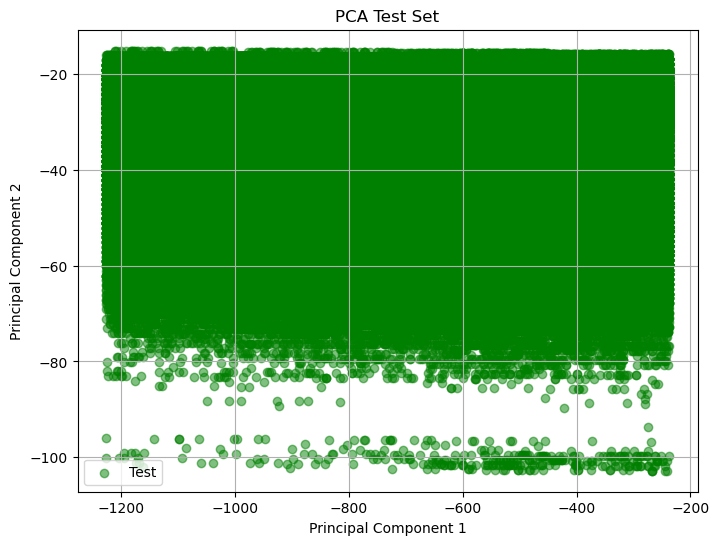

In [55]:
plt.figure(figsize=(8, 6))
plt.scatter(test_numpy[:, 0], test_numpy[:, 1], alpha=0.5, label='Test', color='green')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Test Set')
plt.grid(True)
plt.legend()
plt.show()

In [56]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [60]:
eval = ClusteringEvaluator(featuresCol="features", metricName='silhouette', distanceMeasure='squaredEuclidean')
max_coef = [0, 0]
model = KMeans(featuresCol='features', k=1, seed=42)
for k in [2, 3]:
    kmeans = KMeans(featuresCol='features', k=k, seed=42)
    kmeans_model = kmeans.fit(data_vector_train)
    kmeans_pred = kmeans_model.transform(data_vector_test)
    sil = eval.evaluate(kmeans_pred)
    if sil > max_coef[0]:
        max_coef[0], max_coef[1], model = sil, k, kmeans_model

In [61]:
max_coef

[0.8163603164595161, 2]

In [63]:
kmeans_pred = model.transform(data_vector_test)
cluster_labels = kmeans_pred.select("prediction").distinct().collect()
for label in cluster_labels:
    cluster_df = kmeans_pred.filter(col("prediction") == label["prediction"])
    print(f"Statistics for cluster {label['prediction']}:")
    cluster_df.describe().show()

Statistics for cluster 1:
+-------+-----------------+-------------------+-----------------+--------------------+
|summary|     duration_sec|         Sex_binary|              Age|          prediction|
+-------+-----------------+-------------------+-----------------+--------------------+
|  count|           159054|             159054|           159054|              159054|
|   mean|619.1560979290052| 0.7088724584103512|28.02324367824764|                 1.0|
| stddev|259.7420167463662|0.45428360483742236|4.918593181352986|1.006783260395888...|
|    min|              237|                  0|               16|                   1|
|    max|             1227|                  1|               38|                   1|
+-------+-----------------+-------------------+-----------------+--------------------+

Statistics for cluster 0:
+-------+-----------------+------------------+-----------------+----------+
|summary|     duration_sec|        Sex_binary|              Age|prediction|
+-------+---

In [25]:
spark.stop()

### **4) All Upwork Job Postings**

In [1]:
import findspark
findspark.init('C:\\spark\\spark-3.3.1-bin-hadoop2\\')
import os
# os.environ['JAVA_HOME'] = 'C:\\java\\jdk-11.0.2'
os.environ['JAVA_HOME'] = 'C:\\java\\jdk'
os.environ['PATH'] = os.environ['JAVA_HOME'] + '\\bin;' + os.environ['PATH']
os.environ['SPARK_HOME'] = 'C:\\spark\\spark-3.3.1-bin-hadoop2'
os.environ['HADOOP_HOME'] = 'C:\\hadoop'
os.environ['PATH'] = os.environ['SPARK_HOME'] + '\\bin;' + os.environ['PATH']
os.environ['PATH'] = os.environ['HADOOP_HOME'] + '\\bin;' + os.environ['PATH']

print(os.environ['JAVA_HOME'])
print(os.environ['SPARK_HOME'])
print(os.environ['HADOOP_HOME'])
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, LongType, FloatType, ArrayType, BooleanType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.sql.functions import udf
from pyspark.ml.linalg import DenseVector
import numpy as np
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.types import DoubleType, DateType
from pyspark.sql.functions import col, to_date, datediff, round, expr, lit, min, count, when
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.feature import PCA
from pyspark.ml.functions import vector_to_array
import matplotlib.pyplot as plt
import seaborn as sns


C:\java\jdk
C:\spark\spark-3.3.1-bin-hadoop2
C:\hadoop


In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

api.dataset_download_files('asaniczka/all-jobs-on-upwork-200k-plus', path='./', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/asaniczka/all-jobs-on-upwork-200k-plus


In [2]:
# Создание Spark сессии
spark = SparkSession.builder \
                    .appName("JobDataset") \
                    .getOrCreate()

In [159]:
data1 = spark.read.csv("all_upwork_jobs_2024-02-07-2024-03-24.csv", header=True)
data2 = spark.read.csv("all_upwork_jobs_2024-03-24-2024-05-21.csv", header=True)
data3 = spark.read.csv("all_upwork_jobs_2024-05-21-2024-07-25.csv", header=True)

In [160]:
data_combined = data1.union(data2).union(data3)
data_combined.show()

+--------------------+--------------------+--------------------+---------+----------+-----------+------+--------------+
|               title|                link|      published_date|is_hourly|hourly_low|hourly_high|budget|       country|
+--------------------+--------------------+--------------------+---------+----------+-----------+------+--------------+
|Experienced Media...|https://www.upwor...|2024-02-17 09:09:...|    False|      null|       null| 500.0|          null|
|Full Stack Developer|https://www.upwor...|2024-02-17 09:09:...|    False|      null|       null|1100.0| United States|
|     SMMA Bubble App|https://www.upwor...|2024-02-17 09:08:...|     True|      10.0|       30.0|  null| United States|
|Talent Hunter Spe...|https://www.upwor...|2024-02-17 09:08:...|     True|      null|       null|  null| United States|
|       Data Engineer|https://www.upwor...|2024-02-17 09:07:...|    False|      null|       null| 650.0|         India|
|SEO for Portugues...|https://www.upwor.

In [161]:
data_combined.printSchema()

root
 |-- title: string (nullable = true)
 |-- link: string (nullable = true)
 |-- published_date: string (nullable = true)
 |-- is_hourly: string (nullable = true)
 |-- hourly_low: string (nullable = true)
 |-- hourly_high: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- country: string (nullable = true)



In [162]:
num_rows = data_combined.count()
num_columns = len(data_combined.columns)
print(f"Количество строк: {num_rows}")
print(f"Количество колонок: {num_columns}")

Количество строк: 827149
Количество колонок: 8


In [163]:
data_combined = data_combined.withColumn("is_hourly",
                                          when(col("is_hourly") == "True", 1) \
                                         .when(col("is_hourly") == "False", 0)
                                         .otherwise(None) \
                                         .cast(IntegerType())
)
for colmn in ['hourly_low', 'hourly_high', 'budget']:
    data_combined  = data_combined.withColumn(colmn, round(data_combined[colmn].cast(FloatType()), 3))

In [164]:
data_combined.show()

+--------------------+--------------------+--------------------+---------+----------+-----------+------+--------------+
|               title|                link|      published_date|is_hourly|hourly_low|hourly_high|budget|       country|
+--------------------+--------------------+--------------------+---------+----------+-----------+------+--------------+
|Experienced Media...|https://www.upwor...|2024-02-17 09:09:...|        0|      null|       null| 500.0|          null|
|Full Stack Developer|https://www.upwor...|2024-02-17 09:09:...|        0|      null|       null|1100.0| United States|
|     SMMA Bubble App|https://www.upwor...|2024-02-17 09:08:...|        1|      10.0|       30.0|  null| United States|
|Talent Hunter Spe...|https://www.upwor...|2024-02-17 09:08:...|        1|      null|       null|  null| United States|
|       Data Engineer|https://www.upwor...|2024-02-17 09:07:...|        0|      null|       null| 650.0|         India|
|SEO for Portugues...|https://www.upwor.

In [165]:
columns_res = ["is_hourly", "hourly_low", "hourly_high", "budget"]

In [166]:
data_cleaned = data_combined.dropna(subset=["hourly_low", "hourly_high", "budget"], how='all')

In [167]:
condition_false = (col("hourly_low").isNull()) & (col("hourly_high").isNull()) & col("budget").isNotNull()
condition_true = (col("hourly_low").isNotNull() | col("hourly_high").isNotNull()) & col("budget").isNull()

data_cleaned  = data_cleaned .withColumn("is_hourly", when(condition_false, 0)
                                                      .when(condition_true, 1)
                                        ) \
                             .select(cols_to_keep)

In [12]:
data_cleaned = data_cleaned.dropna(subset=["is_hourly", "country"]).select("is_hourly", "hourly_low", "hourly_high", "budget", "country")

In [13]:
data_cleaned.show()

+---------+----------+-----------+------+--------------+
|is_hourly|hourly_low|hourly_high|budget|       country|
+---------+----------+-----------+------+--------------+
|        0|      null|       null|1100.0| United States|
|        1|      10.0|       30.0|  null| United States|
|        0|      null|       null| 650.0|         India|
|        0|      null|       null|   5.0|         India|
|        1|       7.0|       22.0|  null|         India|
|        0|      null|       null| 500.0|        Canada|
|        0|      null|       null|  50.0|       Germany|
|        0|      null|       null|1200.0| United States|
|        1|      40.0|       75.0|  null|United Kingdom|
|        0|      null|       null| 300.0|       Denmark|
|        1|      30.0|       50.0|  null|      Malaysia|
|        0|      null|       null|   5.0| United States|
|        0|      null|       null|  20.0|    Bangladesh|
|        1|      12.0|       30.0|  null|         India|
|        1|       4.0|        8

In [14]:
data_cleaned.groupBy(col("country")).count().orderBy(col("count").desc()).show()

+--------------------+------+
|             country| count|
+--------------------+------+
|       United States|282323|
|      United Kingdom| 53311|
|               India| 42935|
|           Australia| 36545|
|              Canada| 31971|
|            Pakistan| 14996|
|             Germany| 12972|
|         Netherlands| 11411|
|United Arab Emirates| 11175|
|              France|  8724|
|           Singapore|  6689|
|               China|  6659|
|               Spain|  6314|
|             Ukraine|  6007|
|         Philippines|  5767|
|              Israel|  5671|
|         Switzerland|  5318|
|        Saudi Arabia|  4709|
|               Italy|  4683|
|          Bangladesh|  3944|
+--------------------+------+
only showing top 20 rows



In [15]:
from pyspark.sql.functions import col, avg

In [16]:
# Первые 20 стран по количеству заказов
top_countries = data_cleaned.groupBy(col("country")).count() \
                            .orderBy(col("count").desc()) \
                            .limit(20) \
                            .select("country") \
                            .rdd.flatMap(lambda x: x).collect()

In [17]:
# Почасовая ставка
hourly_data = data_cleaned.filter(col("is_hourly") == 1) \
                           .groupBy("country") \
                           .agg(avg((col("hourly_low") + col("hourly_high")) / 2).alias("avg_hourly_rate")) \
                           .filter(col("country").isin(top_countries))

In [18]:
# Фиксированная ставка
fixed_data = data_cleaned.filter(col("is_hourly") == 0) \
                         .groupBy("country") \
                         .agg(avg("budget").alias("avg_budget")) \
                         .filter(col("country").isin(top_countries))

In [19]:
hourly_count = data_cleaned.filter(col("is_hourly") == 1) \
                           .groupBy("country") \
                           .count() \
                           .withColumnRenamed("count", "hourly_count") \
                           .filter(col("country").isin(top_countries))

In [20]:
fixed_count = data_cleaned.filter(col("is_hourly") == 0) \
                          .groupBy("country") \
                          .count() \
                          .withColumnRenamed("count", "fixed_count") \
                          .filter(col("country").isin(top_countries))

In [21]:
# Отношение количества заказов с почасовой ставкой к количеству заказов с фиксированной ставкой
ratio_data = hourly_count.join(fixed_count, on="country", how="inner") \
                         .withColumn("hourly_fixed_ratio", col("hourly_count") / col("fixed_count")) \
                         .select("country", "hourly_fixed_ratio")

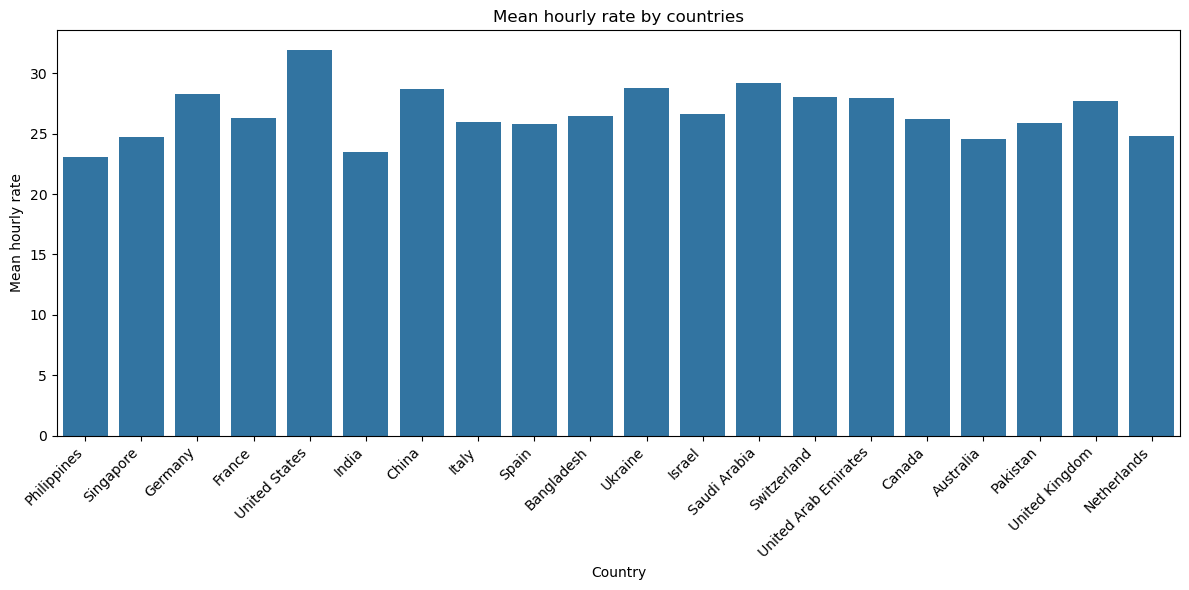

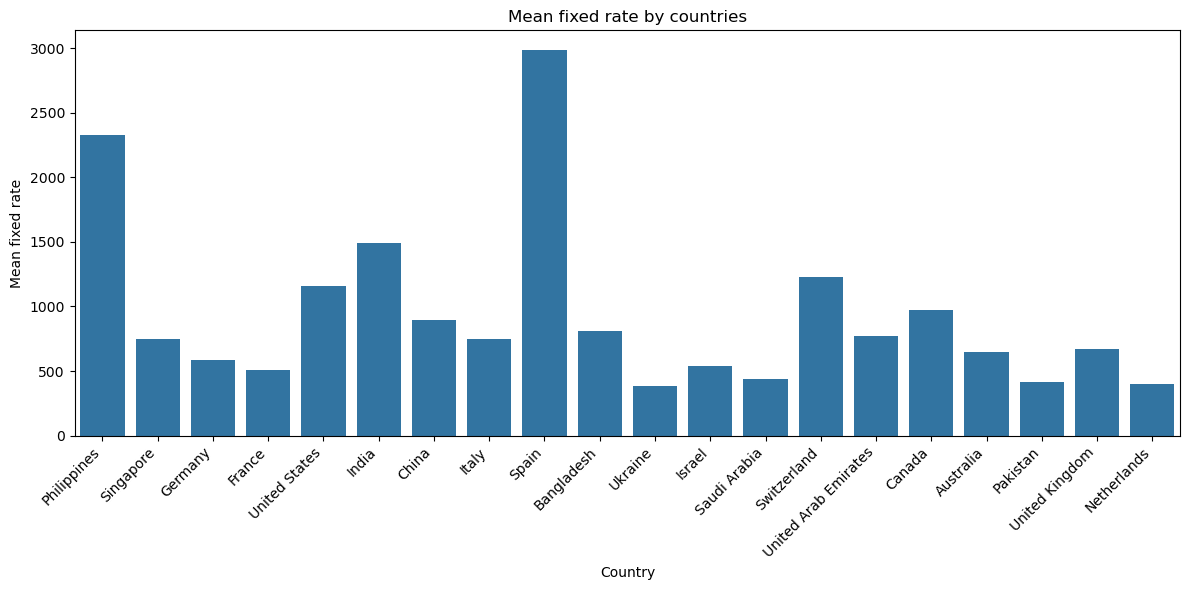

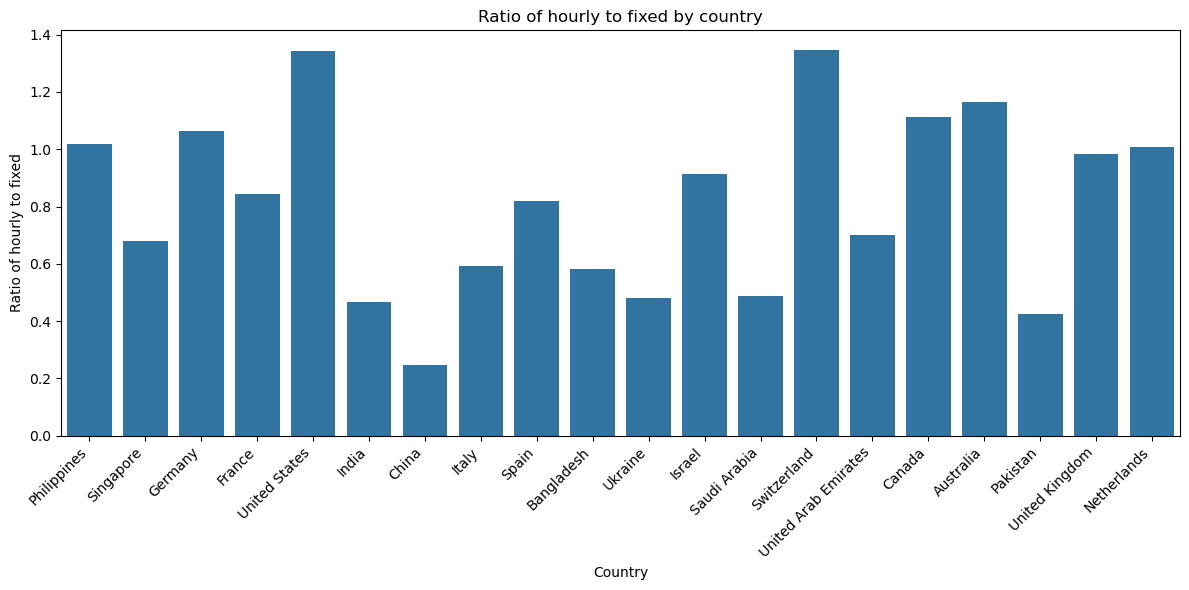

In [24]:
hourly_data_pd = hourly_data.toPandas()
fixed_data_pd = fixed_data.toPandas()
ratio_data_pd = ratio_data.toPandas()

# Шаг 3: Визуализация

# Визуализация почасовых ставок по странам
plt.figure(figsize=(12, 6))
sns.barplot(data=hourly_data_pd, x='country', y='avg_hourly_rate')
plt.title("Mean hourly rate by countries")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Country")
plt.ylabel("Mean hourly rate")
plt.tight_layout()
plt.show()

# Визуализация фиксированных ставок по странам
plt.figure(figsize=(12, 6))
sns.barplot(data=fixed_data_pd, x='country', y='avg_budget')
plt.title("Mean fixed rate by countries")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Country")
plt.ylabel("Mean fixed rate")
plt.tight_layout()
plt.show()

# Визуализация отношения количества заказов
plt.figure(figsize=(12, 6))
sns.barplot(data=ratio_data_pd, x='country', y='hourly_fixed_ratio')
plt.title("Ratio of hourly to fixed by country")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Country")
plt.ylabel("Ratio of hourly to fixed")
plt.tight_layout()
plt.show()

In [25]:
cols_to_keep_hourly = ["hourly_low", "hourly_high"]
colt_to_keep_budget = ["budget"]

In [26]:
vector_transformer = VectorAssembler(inputCols=cols_to_keep_hourly, outputCol='features', handleInvalid="skip")
data_vector = vector_transformer.transform(data_cleaned)

In [27]:
data_vector.columns

['is_hourly', 'hourly_low', 'hourly_high', 'budget', 'country', 'features']

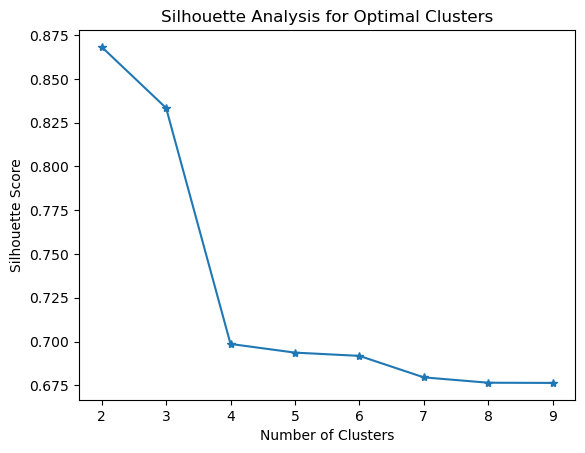

In [28]:
eval = ClusteringEvaluator(featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
sils = []
for k in range(2, 10):
    kmeans = KMeans(k=k, featuresCol='features', seed=42)
    model = kmeans.fit(data_vector)
    pred = model.transform(data_vector)
    sil = eval.evaluate(pred)
    sils.append(sil)

plt.plot(range(2, 10), sils, marker='*')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal Clusters')
plt.show()

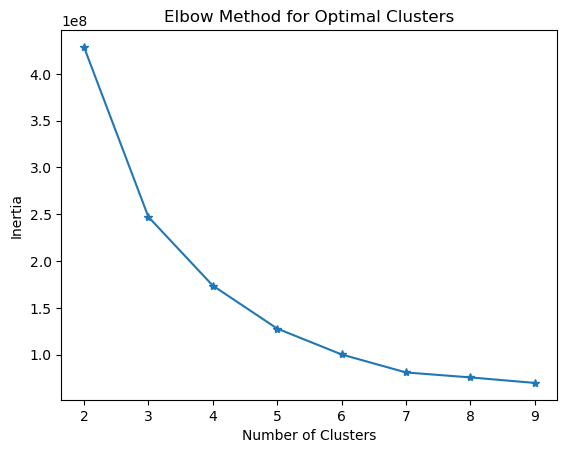

In [29]:
inerts = []
for k in range(2, 10):
    kmeans = KMeans(k=k, featuresCol='features', seed=42)
    model = kmeans.fit(data_vector)
    inerts.append(model.summary.trainingCost)

plt.plot(range(2, 10), inerts, marker='*')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

In [30]:
kmeans = KMeans(k=2, featuresCol='features', seed=42)
model = kmeans.fit(data_vector)
kmeans_pred = model.transform(data_vector)
cluster_labels = kmeans_pred.select("prediction").distinct().collect()
for label in cluster_labels:
    cluster_df = kmeans_pred.filter(col("prediction") == label["prediction"])
    print(f"Statistics for cluster {label['prediction']}:")
    cluster_df.describe().show()

Statistics for cluster 1:
+-------+---------+------------------+------------------+------+--------+----------+
|summary|is_hourly|        hourly_low|       hourly_high|budget| country|prediction|
+-------+---------+------------------+------------------+------+--------+----------+
|  count|   294827|            294827|            294827|     0|  294827|    294827|
|   mean|      1.0|14.440665203661808| 32.17297601644354|  null|    null|       1.0|
| stddev|      0.0| 9.654502280674379|18.609541145253296|  null|    null|       0.0|
|    min|        1|               3.0|               3.0|  null|     ALB|         1|
|    max|        1|              70.0|              96.0|  null|Zimbabwe|         1|
+-------+---------+------------------+------------------+------+--------+----------+

Statistics for cluster 0:
+-------+---------+------------------+------------------+------+--------+----------+
|summary|is_hourly|        hourly_low|       hourly_high|budget| country|prediction|
+-------+---

In [31]:
cols_to_keep_hourly = ["hourly_low", "hourly_high"]
colt_to_keep_budget = ["budget"]

In [32]:
vector_transformer = VectorAssembler(inputCols=colt_to_keep_budget, outputCol='features', handleInvalid="skip")
data_vector = vector_transformer.transform(data_cleaned)

In [33]:
data_vector.columns

['is_hourly', 'hourly_low', 'hourly_high', 'budget', 'country', 'features']

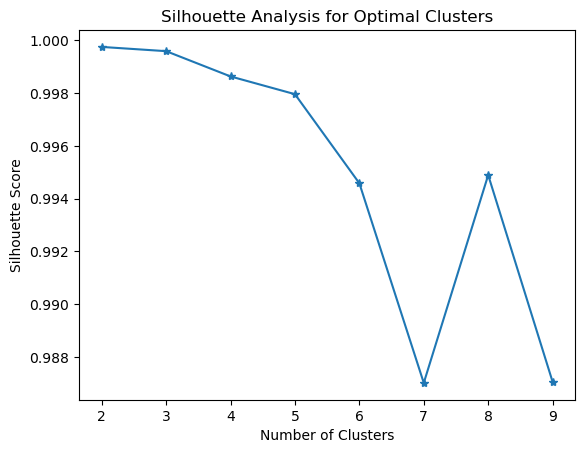

In [34]:
eval = ClusteringEvaluator(featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
sils = []
for k in range(2, 10):
    kmeans = KMeans(k=k, featuresCol='features', seed=42)
    model = kmeans.fit(data_vector)
    pred = model.transform(data_vector)
    sil = eval.evaluate(pred)
    sils.append(sil)

plt.plot(range(2, 10), sils, marker='*')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal Clusters')
plt.show()

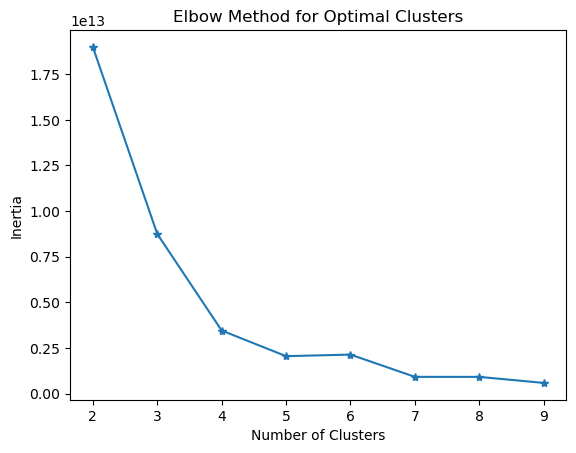

In [35]:
inerts = []
for k in range(2, 10):
    kmeans = KMeans(k=k, featuresCol='features', seed=42)
    model = kmeans.fit(data_vector)
    inerts.append(model.summary.trainingCost)

plt.plot(range(2, 10), inerts, marker='*')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

In [36]:
kmeans = KMeans(k=3, featuresCol='features', seed=42)
model = kmeans.fit(data_vector)
kmeans_pred = model.transform(data_vector)
cluster_labels = kmeans_pred.select("prediction").distinct().collect()
for label in cluster_labels:
    cluster_df = kmeans_pred.filter(col("prediction") == label["prediction"])
    print(f"Statistics for cluster {label['prediction']}:")
    cluster_df.describe().show()

Statistics for cluster 1:
+-------+---------+----------+-----------+-----------------+---------+----------+
|summary|is_hourly|hourly_low|hourly_high|           budget|  country|prediction|
+-------+---------+----------+-----------+-----------------+---------+----------+
|  count|       81|         0|          0|               81|       81|        81|
|   mean|      0.0|      null|       null|993753.2962962963|     null|       1.0|
| stddev|      0.0|      null|       null|32950.15227144043|     null|       0.0|
|    min|        0|      null|       null|         800000.0|Argentina|         1|
|    max|        0|      null|       null|        1000000.0|  Vietnam|         1|
+-------+---------+----------+-----------+-----------------+---------+----------+

Statistics for cluster 0:
+-------+---------+----------+-----------+-----------------+-----------------+----------+
|summary|is_hourly|hourly_low|hourly_high|           budget|          country|prediction|
+-------+---------+----------

### **5) European Soccer Database**

In [117]:
import findspark
findspark.init('C:\\spark\\spark-3.3.1-bin-hadoop2\\')
import os
# os.environ['JAVA_HOME'] = 'C:\\java\\jdk-11.0.2'
os.environ['JAVA_HOME'] = 'C:\\java\\jdk'
os.environ['PATH'] = os.environ['JAVA_HOME'] + '\\bin;' + os.environ['PATH']
os.environ['SPARK_HOME'] = 'C:\\spark\\spark-3.3.1-bin-hadoop2'
os.environ['HADOOP_HOME'] = 'C:\\hadoop'
os.environ['PATH'] = os.environ['SPARK_HOME'] + '\\bin;' + os.environ['PATH']
os.environ['PATH'] = os.environ['HADOOP_HOME'] + '\\bin;' + os.environ['PATH']

print(os.environ['JAVA_HOME'])
print(os.environ['SPARK_HOME'])
print(os.environ['HADOOP_HOME'])
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, LongType, FloatType, ArrayType, BooleanType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.sql.functions import udf
from pyspark.ml.linalg import DenseVector
import numpy as np
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.types import DoubleType, DateType
from pyspark.sql.functions import col, to_date, datediff, round, expr, lit, min, count, when, mean, abs
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.feature import PCA
from pyspark.ml.functions import vector_to_array
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3
from pyspark.sql.functions import col, when

C:\java\jdk
C:\spark\spark-3.3.1-bin-hadoop2
C:\hadoop


In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

api.dataset_download_files('hugomathien/soccer', path='./', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/hugomathien/soccer


In [2]:
# Создание Spark сессии
spark = SparkSession.builder \
                    .config("spark.jars.packages", "org.xerial:sqlite-jdbc:3.36.0.3") \
                    .appName("SoccerDataset") \
                    .getOrCreate()

In [39]:
soccer_path = './soccer/database.sqlite'
connection = f'sqlite:///{soccer_path}'
tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""",
                     connection)

In [40]:
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [41]:
data = spark.read.format('jdbc').options(driver='org.sqlite.JDBC',
                                         dbtable='Player_Attributes',
                                         url='jdbc:sqlite:soccer//database.sqlite'
                                        ).load()

In [42]:
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- player_fifa_api_id: integer (nullable = true)
 |-- player_api_id: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- overall_rating: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- preferred_foot: string (nullable = true)
 |-- attacking_work_rate: string (nullable = true)
 |-- defensive_work_rate: string (nullable = true)
 |-- crossing: integer (nullable = true)
 |-- finishing: integer (nullable = true)
 |-- heading_accuracy: integer (nullable = true)
 |-- short_passing: integer (nullable = true)
 |-- volleys: integer (nullable = true)
 |-- dribbling: integer (nullable = true)
 |-- curve: integer (nullable = true)
 |-- free_kick_accuracy: integer (nullable = true)
 |-- long_passing: integer (nullable = true)
 |-- ball_control: integer (nullable = true)
 |-- acceleration: integer (nullable = true)
 |-- sprint_speed: integer (nullable = true)
 |-- agility: integer (nullable = true)
 |-- reactions: integ

In [43]:
data.count()

183978

In [44]:
data = data.dropna()
data.count()

180354

In [45]:
unique_counts = {col: data.select(col).distinct().count() for col in data.columns}
for col, count in unique_counts.items():
    print(f"Колонка '{col}': {count} уникальных значений")

Колонка 'id': 180354 уникальных значений
Колонка 'player_fifa_api_id': 10410 уникальных значений
Колонка 'player_api_id': 10410 уникальных значений
Колонка 'date': 197 уникальных значений
Колонка 'overall_rating': 61 уникальных значений
Колонка 'potential': 56 уникальных значений
Колонка 'preferred_foot': 2 уникальных значений
Колонка 'attacking_work_rate': 8 уникальных значений
Колонка 'defensive_work_rate': 18 уникальных значений
Колонка 'crossing': 95 уникальных значений
Колонка 'finishing': 97 уникальных значений
Колонка 'heading_accuracy': 96 уникальных значений
Колонка 'short_passing': 95 уникальных значений
Колонка 'volleys': 93 уникальных значений
Колонка 'dribbling': 97 уникальных значений
Колонка 'curve': 92 уникальных значений
Колонка 'free_kick_accuracy': 97 уникальных значений
Колонка 'long_passing': 95 уникальных значений
Колонка 'ball_control': 93 уникальных значений
Колонка 'acceleration': 86 уникальных значений
Колонка 'sprint_speed': 85 уникальных значений
Колонка 'ag

In [46]:
data.select(['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']).show()

+--------------+-------------------+-------------------+
|preferred_foot|attacking_work_rate|defensive_work_rate|
+--------------+-------------------+-------------------+
|         right|             medium|             medium|
|         right|             medium|             medium|
|         right|             medium|             medium|
|         right|             medium|             medium|
|         right|             medium|             medium|
|          left|               high|             medium|
|          left|               high|             medium|
|          left|               high|             medium|
|          left|               high|             medium|
|          left|               high|             medium|
|          left|               high|             medium|
|          left|               high|             medium|
|          left|             medium|             medium|
|          left|             medium|             medium|
|          left|             me

In [47]:
for col in ['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']:
    print(f"Уникальные значения и их количество для колонки '{col}':")
    data.groupBy(col).count().orderBy("count", ascending=False).show(truncate=False)

Уникальные значения и их количество для колонки 'preferred_foot':
+--------------+------+
|preferred_foot|count |
+--------------+------+
|right         |136247|
|left          |44107 |
+--------------+------+

Уникальные значения и их количество для колонки 'attacking_work_rate':
+-------------------+------+
|attacking_work_rate|count |
+-------------------+------+
|medium             |125070|
|high               |42823 |
|low                |8569  |
|None               |3317  |
|norm               |317   |
|y                  |94    |
|stoc               |86    |
|le                 |78    |
+-------------------+------+

Уникальные значения и их количество для колонки 'defensive_work_rate':
+-------------------+------+
|defensive_work_rate|count |
+-------------------+------+
|medium             |130846|
|high               |27041 |
|low                |18432 |
|o                  |1328  |
|1                  |421   |
|2                  |334   |
|ormal              |317   |
|3      

In [56]:
from pyspark.sql.functions import col, when

In [50]:
# Удаление строк с None в колонке 'attacking_work_rate'
data = data.filter(col("attacking_work_rate") != "None")

In [51]:
# Преобразование колонки 'attacking_work_rate'
data = data.withColumn(
    "attacking_work_rate",
    when(col("attacking_work_rate") == "norm", "medium")
    .otherwise(col("attacking_work_rate"))
)

In [52]:
# Преобразование колонки 'defensive_work_rate'
data = data.withColumn(
    "defensive_work_rate",
    when(col("defensive_work_rate") == "ormal", "medium")
    .when(col("defensive_work_rate").isin(["o", "1", "2"]), "low")
    .when(col("defensive_work_rate").isin(["3", "4", "5", "6"]), "medium")
    .when(col("defensive_work_rate").isin(["7", "8", "9"]), "high")
    .when(col("defensive_work_rate").isin(["es", "tocky", "ean"]), None)
    .when(col("defensive_work_rate").isin(["high", "medium", "low"]), col("defensive_work_rate"))
    .otherwise(None)
)
data = data.filter(col("defensive_work_rate").isNotNull())

In [53]:
for column in ['attacking_work_rate', 'defensive_work_rate']:
    data = data.withColumn(
        column,
        when(col(column) == "low", 0)
        .when(col(column) == "medium", 1)
        .when(col(column) == "high", 2)
        )

In [54]:
data = data.withColumn(
    "preferred_foot",
    when(col("preferred_foot") == "right", 0)
    .when(col("preferred_foot") == "left", 1)
    )

In [60]:
for column in ['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']:
    print(f"Уникальные значения и их количество для колонки '{column}':")
    data.groupBy(column).count().orderBy("count", ascending=False).show(truncate=False)

Уникальные значения и их количество для колонки 'preferred_foot':
+--------------+------+
|preferred_foot|count |
+--------------+------+
|0             |133603|
|1             |43156 |
+--------------+------+

Уникальные значения и их количество для колонки 'attacking_work_rate':
+-------------------+------+
|attacking_work_rate|count |
+-------------------+------+
|1                  |125378|
|2                  |42812 |
|0                  |8569  |
+-------------------+------+

Уникальные значения и их количество для колонки 'defensive_work_rate':
+-------------------+------+
|defensive_work_rate|count |
+-------------------+------+
|1                  |131193|
|2                  |27008 |
|0                  |18558 |
+-------------------+------+



In [63]:
data = data.drop("id", "player_fifa_api_id", "player_api_id", "date")

In [64]:
data.printSchema()

root
 |-- overall_rating: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- preferred_foot: integer (nullable = true)
 |-- attacking_work_rate: integer (nullable = true)
 |-- defensive_work_rate: integer (nullable = true)
 |-- crossing: integer (nullable = true)
 |-- finishing: integer (nullable = true)
 |-- heading_accuracy: integer (nullable = true)
 |-- short_passing: integer (nullable = true)
 |-- volleys: integer (nullable = true)
 |-- dribbling: integer (nullable = true)
 |-- curve: integer (nullable = true)
 |-- free_kick_accuracy: integer (nullable = true)
 |-- long_passing: integer (nullable = true)
 |-- ball_control: integer (nullable = true)
 |-- acceleration: integer (nullable = true)
 |-- sprint_speed: integer (nullable = true)
 |-- agility: integer (nullable = true)
 |-- reactions: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- shot_power: integer (nullable = true)
 |-- jumping: integer (nullable = true)
 |-- stamina: integer

In [69]:
data.count()

176759

In [65]:
vector_transformer = VectorAssembler(inputCols=data.columns, outputCol='features')
data_vector = vector_transformer.transform(data)

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.stat import Correlation

In [67]:
correlation_matrix = Correlation.corr(data_vector, 'features').head()[0]
corr_matrix_np = correlation_matrix.toArray()

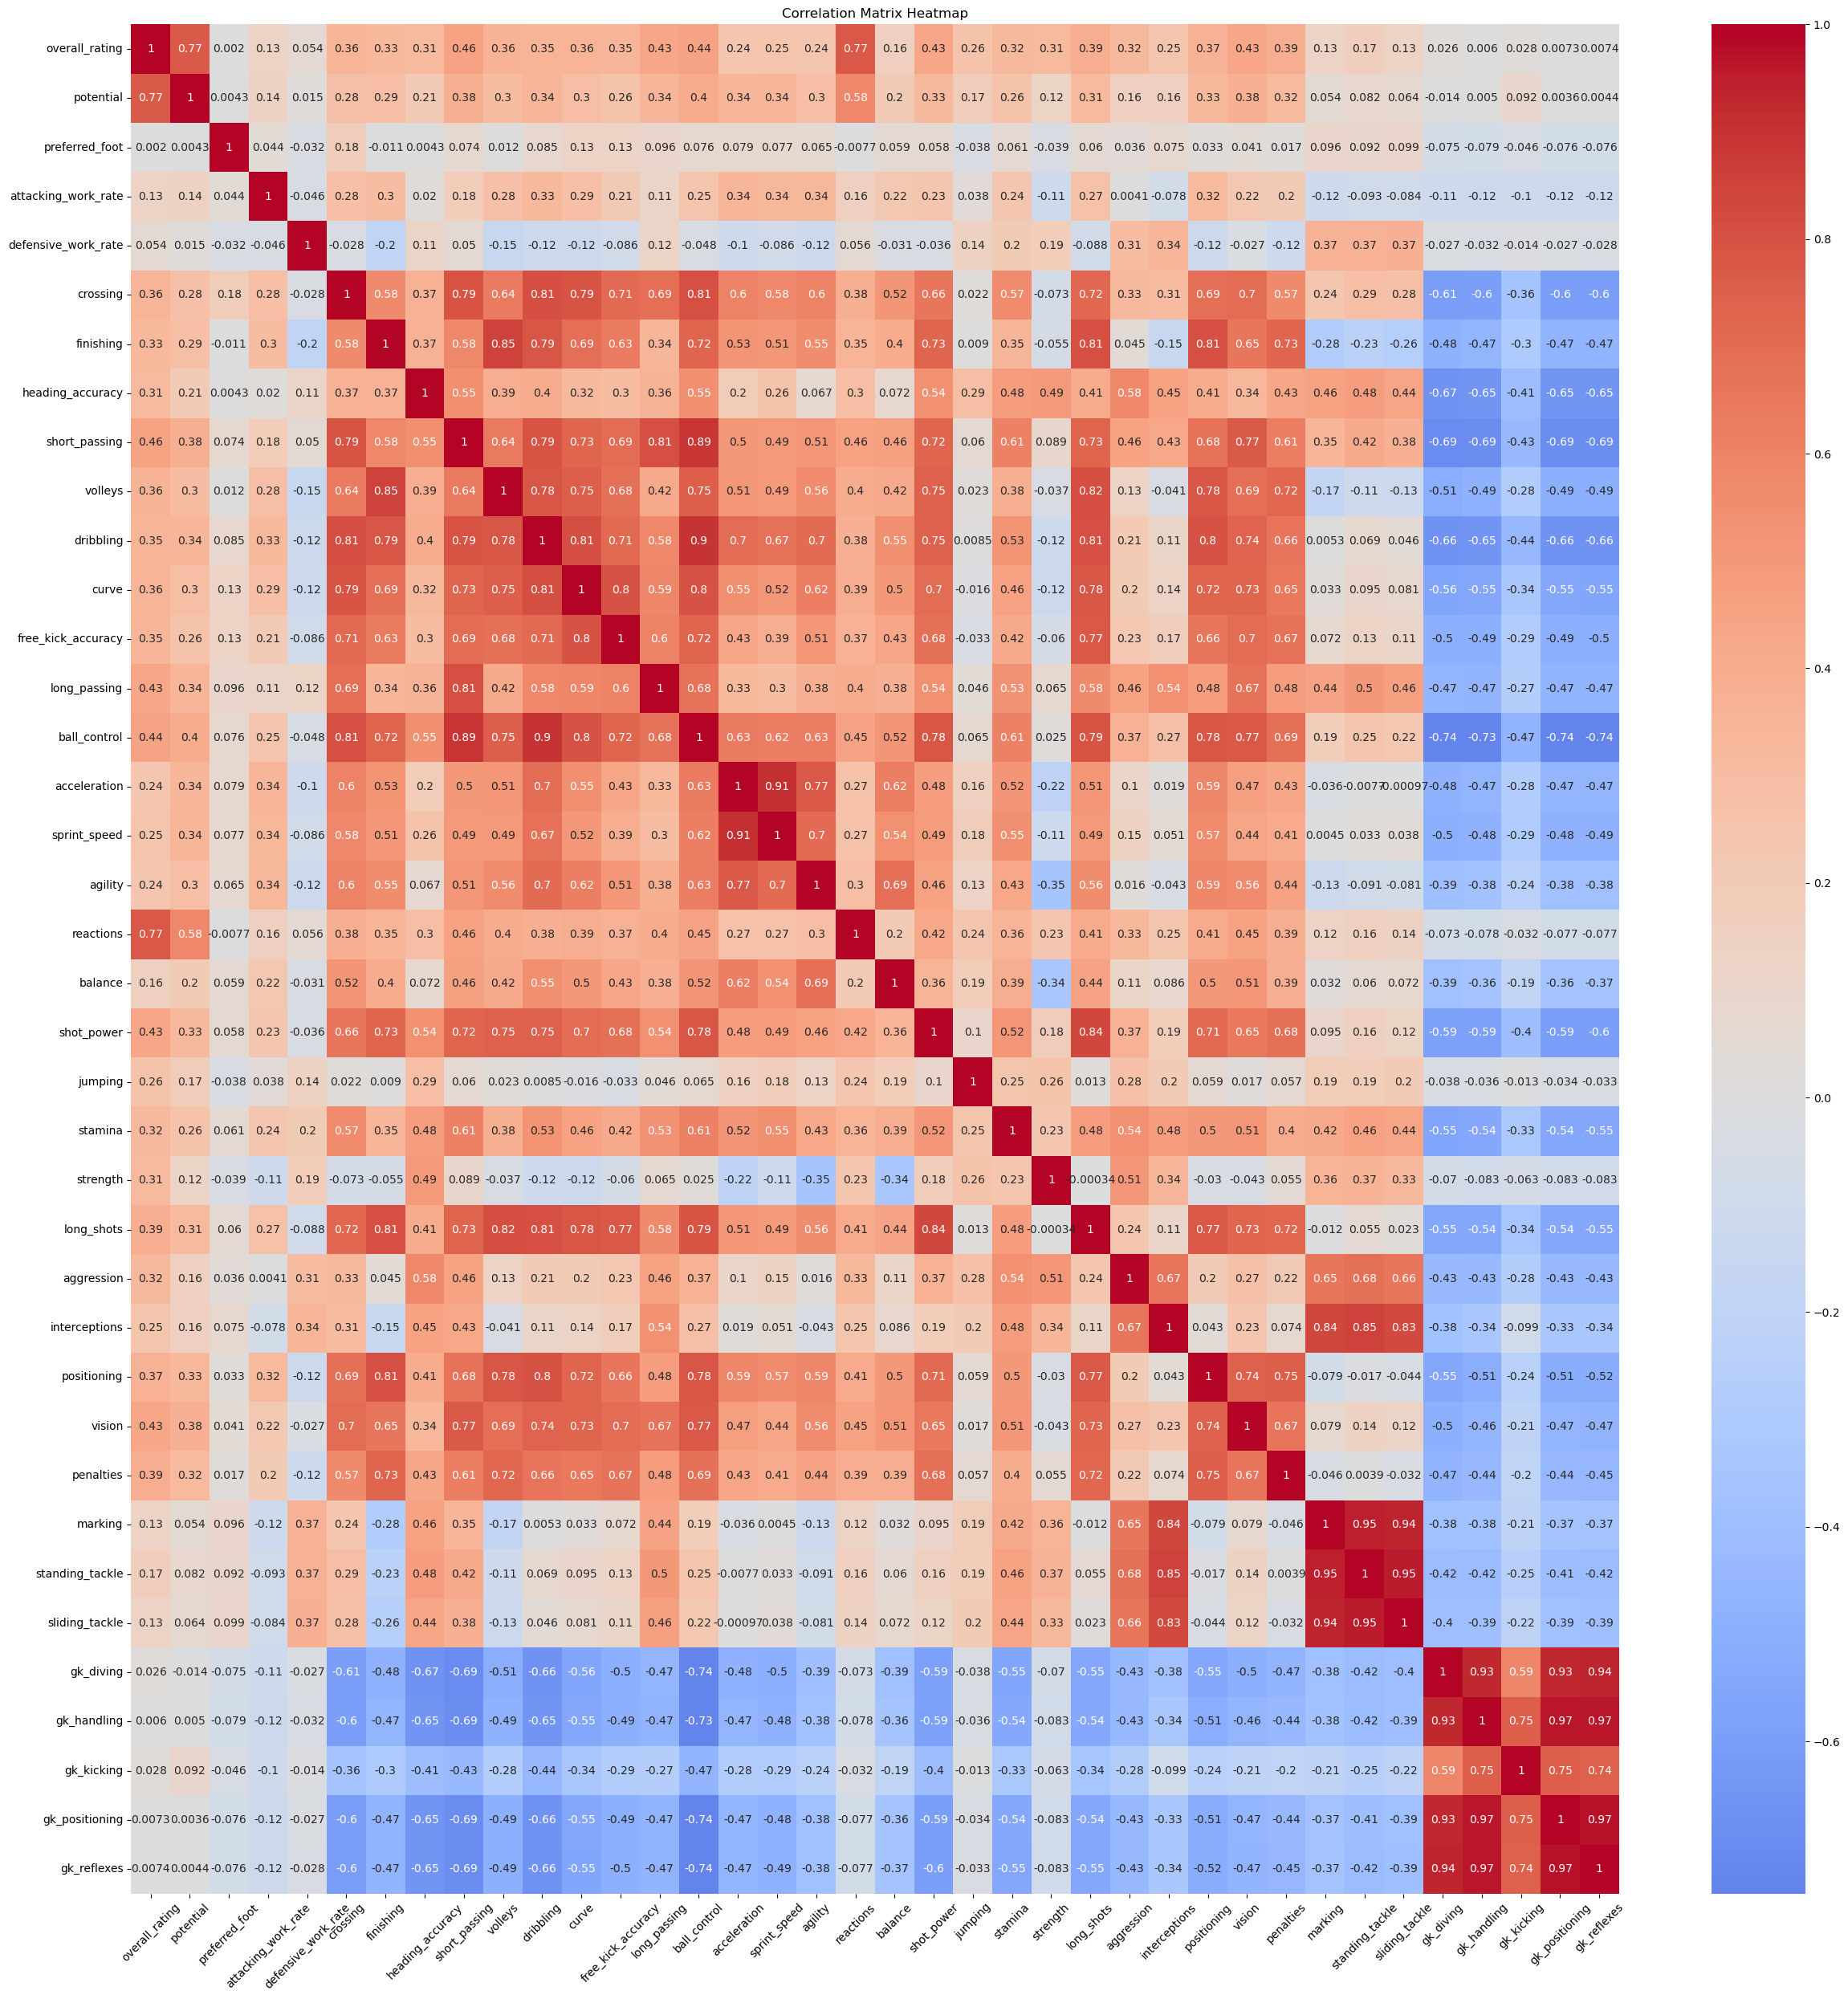

In [71]:
plt.figure(figsize=(25, 25))
sns.heatmap(corr_matrix_np,
            annot=True,
            xticklabels=data.columns,
            yticklabels=data.columns,
            cmap='coolwarm',
            center=0
           )
plt.title("Correlation Matrix Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Попробуем предсказывать overall_rating по всем параметрам

In [89]:
data.select('overall_rating').describe().show()

+-------+-----------------+
|summary|   overall_rating|
+-------+-----------------+
|  count|           176759|
|   mean|68.67820591879338|
| stddev|7.030959573045386|
|    min|               33|
|    max|               94|
+-------+-----------------+



In [76]:
columns_fit = data.columns[1:]

In [79]:
data_to_analyse = data.sample(withReplacement=False, fraction=1.0, seed=42)
data_train, data_test = data.randomSplit([0.9, 0.1], seed=42)

In [80]:
vector_transformer = VectorAssembler(inputCols=columns_fit, outputCol='features')
data_vector_train = vector_transformer.transform(data_train)
data_vector_test = vector_transformer.transform(data_test)

In [81]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(data_vector_train)
data_scaled_train = scaler_model.transform(data_vector_train)
data_scaled_test = scaler_model.transform(data_vector_test)

In [91]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor

In [92]:
linreg = LinearRegression(featuresCol="scaled_features", labelCol="overall_rating")
linreg_model = linreg.fit(data_scaled_train)
linreg_pred = linreg_model.transform(data_scaled_test)

In [93]:
eval = RegressionEvaluator(labelCol="overall_rating", predictionCol="prediction")
rmse = eval.setMetricName("rmse").evaluate(linreg_pred)
mae = eval.setMetricName("mae").evaluate(linreg_pred)
r2 = eval.setMetricName("r2").evaluate(linreg_pred)
mse = eval.setMetricName("mse").evaluate(linreg_pred)
print(f"Linear Regressiom regression metrics on test:")
print(f"  RMSE: {rmse}")
print(f"  MAE: {mae}")
print(f"  R2: {r2}")
print(f"  MSE: {mse}\n")

Linear Regressiom regression metrics on test:
  RMSE: 2.7693893178183826
  MAE: 2.114864383538449
  R2: 0.8427621093670035
  MSE: 7.669517193646567



In [94]:
rfreg = RandomForestRegressor(featuresCol="scaled_features", labelCol="overall_rating", numTrees=10)
rfreg_model = rfreg.fit(data_scaled_train)
rfreg_pred = rfreg_model.transform(data_scaled_test)

In [95]:
eval = RegressionEvaluator(labelCol="overall_rating", predictionCol="prediction")
rmse = eval.setMetricName("rmse").evaluate(rfreg_pred)
mae = eval.setMetricName("mae").evaluate(rfreg_pred)
r2 = eval.setMetricName("r2").evaluate(rfreg_pred)
mse = eval.setMetricName("mse").evaluate(rfreg_pred)
print(f"Random Forest Regressor regression metrics on test:")
print(f"  RMSE: {rmse}")
print(f"  MAE: {mae}")
print(f"  R2: {r2}")
print(f"  MSE: {mse}\n")

Random Forest Regressor regression metrics on test:
  RMSE: 2.76937082977345
  MAE: 1.9732762575888776
  R2: 0.8427642087550996
  MSE: 7.669414792800087



### Попробуем кластеризовать и посмотреть, какие кластеры можно выделить

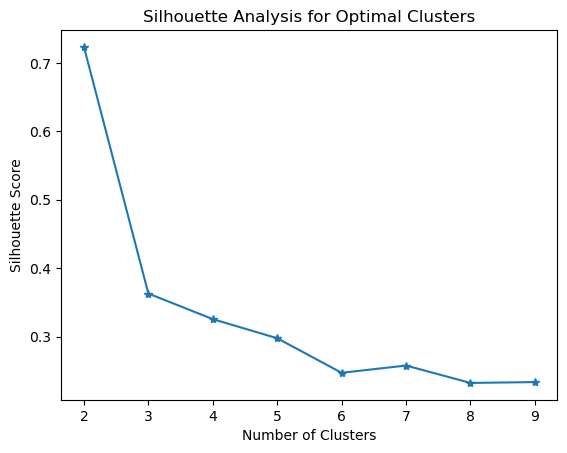

In [96]:
eval = ClusteringEvaluator(featuresCol='scaled_features', metricName='silhouette', distanceMeasure='squaredEuclidean')
sils = []
for k in range(2, 10):
    kmeans = KMeans(k=k, featuresCol='scaled_features', seed=42)
    model = kmeans.fit(data_scaled_train)
    pred = model.transform(data_scaled_train)
    sil = eval.evaluate(pred)
    sils.append(sil)

plt.plot(range(2, 10), sils, marker='*')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal Clusters')
plt.show()

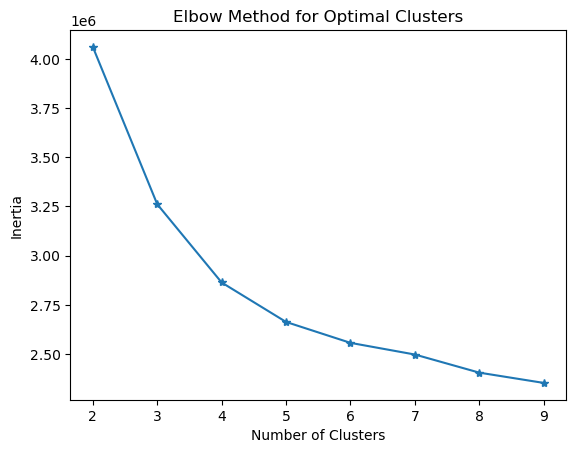

In [97]:
inerts = []
for k in range(2, 10):
    kmeans = KMeans(k=k, featuresCol='scaled_features', seed=42)
    model = kmeans.fit(data_scaled_train)
    inerts.append(model.summary.trainingCost)

plt.plot(range(2, 10), inerts, marker='*')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

In [109]:
kmeans = KMeans(k=2, featuresCol='scaled_features', seed=42)
model = kmeans.fit(data_scaled_train)
kmeans_pred = model.transform(data_scaled_train)

In [121]:
cluster_means = {}
for label in kmeans_pred.select("prediction").distinct().collect():
    label = label["prediction"]
    cluster_df = kmeans_pred.filter(col("prediction") == label)
    means = cluster_df.select([mean(column).alias(column) for column in data.columns[1:]]).collect()[0].asDict()
    cluster_means[label] = means

In [122]:
mean_differences = {}
for column in data.columns[1:]:
    mean_differences[column] = np.abs(cluster_means[0][column] - cluster_means[1][column])

In [123]:
sorted_mean_differences = sorted(mean_differences.items(), key=lambda x: x[1], reverse=True)
print("Top features contributing to cluster separation:")
for feature, diff in sorted_mean_differences:
    print(f"{feature}: Difference = {diff}")

Top features contributing to cluster separation:
gk_reflexes: Difference = 59.76949854920408
gk_diving: Difference = 59.68029246202697
gk_positioning: Difference = 55.44897349629882
gk_handling: Difference = 54.62268055454513
gk_kicking: Difference = 47.53665162525925
dribbling: Difference = 44.05890223144779
ball_control: Difference = 42.78971186544223
heading_accuracy: Difference = 41.40414789676689
crossing: Difference = 39.666835542546686
curve: Difference = 38.497200577787574
positioning: Difference = 38.15172592888705
long_shots: Difference = 38.07815146538223
short_passing: Difference = 37.483390089871214
shot_power: Difference = 36.164649525331335
volleys: Difference = 35.04747343452259
finishing: Difference = 34.680740465043186
standing_tackle: Difference = 34.0539791425658
free_kick_accuracy: Difference = 33.71236165820092
sliding_tackle: Difference = 32.470015149655694
marking: Difference = 30.695224371611772
vision: Difference = 28.992221566262007
penalties: Difference = 28

In [124]:
cluster_labels = kmeans_pred.select("prediction").distinct().collect()
for label in cluster_labels:
    cluster_df = kmeans_pred.filter(col("prediction") == label["prediction"])
    print(f"Statistics for cluster {label['prediction']}:")
    cluster_df.select('gk_reflexes').describe().show()

Statistics for cluster 1:
+-------+-----------------+
|summary|      gk_reflexes|
+-------+-----------------+
|  count|            12966|
|   mean|71.18494524140058|
| stddev| 9.10090200905464|
|    min|                5|
|    max|               96|
+-------+-----------------+

Statistics for cluster 0:
+-------+------------------+
|summary|       gk_reflexes|
+-------+------------------+
|  count|            145973|
|   mean|11.415446692196502|
| stddev|  4.88773315597722|
|    min|                 1|
|    max|                72|
+-------+------------------+



In [102]:
from pyspark.ml.feature import PCA

In [103]:
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca")
pca_model = pca.fit(data_scaled_train)
pca_res_test = pca_model.transform(data_scaled_test)
pca_res_train = pca_model.transform(data_scaled_train)

In [ ]:
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import 

In [105]:
pca_res_train = pca_res_train.withColumn("pca_array", vector_to_array("pca"))
pca_res_test = pca_res_test.withColumn("pca_array", vector_to_array("pca"))

pca_res_train = pca_res_train.withColumn("PC1", col("pca_array")[0]).withColumn("PC2", col("pca_array")[1])
pca_res_test = pca_res_test.withColumn("PC1", col("pca_array")[0]).withColumn("PC2", col("pca_array")[1])

In [106]:
train_numpy = np.array(pca_res_train.select("PC1", "PC2").collect())
test_numpy = np.array(pca_res_test.select("PC1", "PC2").collect())

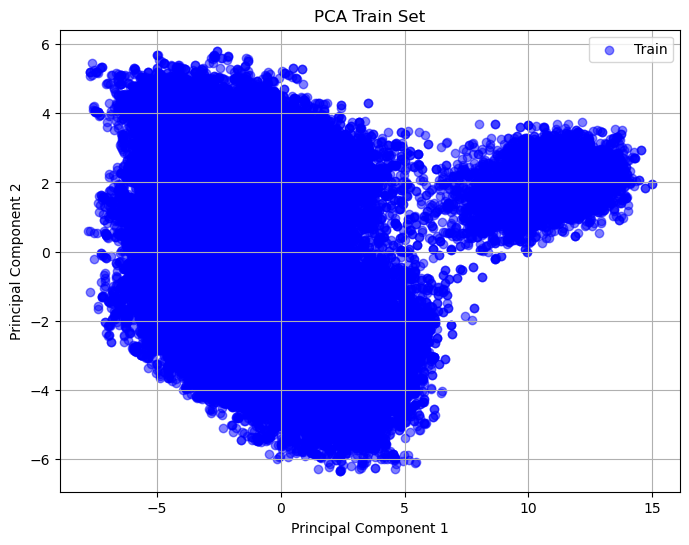

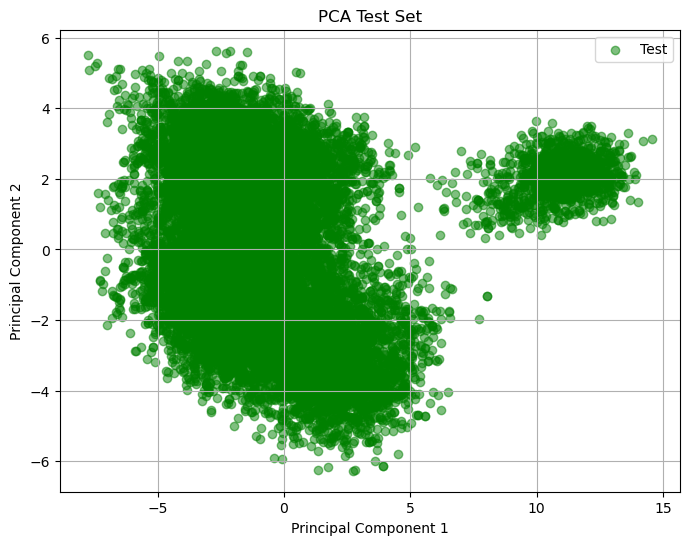

In [107]:
plt.figure(figsize=(8, 6))
plt.scatter(train_numpy[:, 0], train_numpy[:, 1], alpha=0.5, label='Train', color='blue')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Train Set')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(test_numpy[:, 0], test_numpy[:, 1], alpha=0.5, label='Test', color='green')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Test Set')
plt.grid(True)
plt.legend()
plt.show()